# GTHA housing market database
# OSEMN methodology Step 2: Scrub
# Step 2.2 Correction of inconsistent entries in the Teranet dataset

---

This notebook describes Step 2.2 (part of _Step 2: Scrub_ of OSEMN methodology) performed on the Teranet dataset.

Step 2.2 focuses on the correction of inconsistent entries in the Teranet dataset. Cleanup plan is presented below.

Previous steps included: 

* Step 2.1 

    * the spatial join between the Teranet points and the polygons of GTHA Dissemination Areas (DAs)
    
    * During step 2.1, Teranet records whose coordinates fall outside of the GTHA boundary (as defined by the DA geometry) have been filtered out (6,803,691 of the original 9,039,241 Teranet records remain in the dataset)
     
    * In addition to that, three new columns (`OBJECTID`, `DAUID`, and `CSDNAME`) derived from DA attributes have been added to each Teranet transaction

---

For description of OSEMN methodology, see `methodology/0.osemn/osemn.pdf`.

For background information, description of the Teranet dataset, and its attributes, see `methodology/1.obtain/obtain.pdf`.

For description of _Step 2: Scrub_ of OSEMN methodology, see `methodology/2.scrub/scrub.pdf`.

For description of the cleanup plan for the Teranet dataset, see `methodology/2.scrub/teranet_cleanup_plan.pdf`.

For description of Step 2.1 of the cleanup process, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`.

## Cleanup plan

1. Convert column names to lower case
2. Fix inconsistent capitalizations for values in columns:
    * `municipality`
    * `street_name`
    * `street_designation`
    * `postal_code` (do not show problems, preventive measure)
3. Remove column `province`
4. Create a reserve copy of unmodified column `street_name` -- `street_name_raw`
5. Remove municipality mentions from `street_name`
6. Parse `postal_code` from `street_name`
7. Validate consistency of values in column `postal_code`
8. Parse `unitno` from `street_name`
9. Parse `street_number` from `street_name`
10. Parse `street_direction` from `street_name`
11. Parse `street_designation` from `street_name`
12. Investigate missing values
13. Remove column `street_suffix`
14. Fix inconsistent entries in columns:
    * 14.1: `street_direction`
    * 14.2: `street_designation`
    * 14.3: `municipality`
    * 14.4: `street_name`
    * 14.5: `unitno`
    
## Import dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time

sns.set()

In [2]:
data_path = '../../data/teranet/'
os.listdir(data_path)

['1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 'GTAjoinedLanduseSales']

## Load Teranet data

In [3]:
t = time()
df = pd.read_csv(data_path + '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
                 parse_dates=['registration_date'], low_memory=False)
# df = pd.read_csv(data_path + '1.4_Teranet_DA_TAZ_FSA_LU.csv') # parsing dates takes ~21 minutes
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame loaded
in 33.48 seconds (0.56 minutes)
with 6,803,691 rows
and 27 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'DAUID', 'CSDUID',
       'CSDNAME', 'TAZ_O', 'FSA', 'PCA_ID', 'postal_code_dmti', 'pin_lu',
       'LANDUSE', 'PROP_CODE', 'dmti_lu'],
      dtype='object')


## Step 1: convert column names to lower case

In [4]:
df.columns = df.columns.str.lower()
df.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'province', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_suffix', 'street_number', 'x', 'y', 'dauid', 'csduid',
       'csdname', 'taz_o', 'fsa', 'pca_id', 'postal_code_dmti', 'pin_lu',
       'landuse', 'prop_code', 'dmti_lu'],
      dtype='object')

## Step 2: fix inconsistent capitalizations
Inconsistent capitalizations are fixed for values in the following columns: 
* `unitno`
* `street_name`
* `street_designaction`
* `street_direction`
* `municipality`

In [5]:
t = time()
df['municipality'] = df['municipality'].str.title()
df['street_name'] = df['street_name'].str.title()
df['street_designation'] = df['street_designation'].str.capitalize()
df['postal_code'] = df['postal_code'].str.upper()
elapsed = time() - t
print("Capitalizations were fixed! Took {0:,.2f} seconds.".format(elapsed))

Capitalizations were fixed! Took 18.26 seconds.


## Step 3: Remove column `province`

In [6]:
df = df.drop('province', axis=1)
print("Column 'province' was removed from the dataset.")

Column 'province' was removed from the dataset.


## Step 4: Create a reserve copy of unmodified column `street_name` -- `street_name_raw`

In [7]:
df['street_name_raw'] = df['street_name'].values
print("Column `street_name_raw` was created!")

Column `street_name_raw` was created!


## Step 5: Remove municipality mentions from `street_name`

#### Erase ', Mississaug' from the end of 'street_name'

In [8]:
mask1 = df['street_name'].str.contains(',\sMississaug', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
723052,NaN,"130-5260 Mcfarren Blvd, Mississaug",NaN,Mississauga
2606330,NaN,"130-5260 Mcfarren Blvd, Mississaug",NaN,Mississauga
5703862,NaN,"130-5260 Mcfarren Blvd, Mississaug",NaN,Mississauga


In [9]:
df.loc[mask1, 'street_name'] = df.loc[mask1, 'street_name'].str.replace(', Mississaug', '')
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
723052,NaN,130-5260 Mcfarren Blvd,NaN,Mississauga
2606330,NaN,130-5260 Mcfarren Blvd,NaN,Mississauga
5703862,NaN,130-5260 Mcfarren Blvd,NaN,Mississauga


#### Erase ', Vaugh' from the end of 'street_name'

In [10]:
mask1 = df['street_name'].str.contains(',\sVaugh', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
2750236,NaN,"Mactier Drive, Vaughan,",NaN,Vaughan
4774219,NaN,"Mactier Drive, Vaughan,",NaN,Vaughan
4824438,NaN,"Highway 7 West, Vaughan On L4K 0H8",NaN,Richmond Hill
4982723,NaN,"510 Vellore Woods Boulevard, Vaugh",NaN,Vaughan


In [11]:
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name']\
    .str.replace(', Vaughan,', '')\
    .str.replace(', Vaughan On', '')\
    .str.replace(', Vaugh', '')
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
2750236,NaN,Mactier Drive,NaN,Vaughan
4774219,NaN,Mactier Drive,NaN,Vaughan
4824438,NaN,Highway 7 West L4K 0H8,NaN,Richmond Hill
4982723,NaN,510 Vellore Woods Boulevard,NaN,Vaughan


## Step 6: Parse `postal_code` from `street_name`
Some Teranet records with missing `postal_code` have it as part of their `street_name` value.

In [12]:
mask1 = df['street_name'].str.contains('[A-Z]\d[A-Z]\d[A-Z]\d', na=False, case=False)
df.loc[mask1, ['street_name', 'street_designation', 'postal_code', 'municipality']]

,street_name,street_designation,postal_code,municipality
19245,Tooley Rd L1E2K7,NaN,NaN,Courtice
47765,Stainton Street L1E3A1,NaN,NaN,Courtice
76328,Karsh Cres L0R2H0,NaN,NaN,Waterdown
79840,Nelson Street L0R2H0,NaN,NaN,Waterdown
96813,Orchard Park Blvd M4L3E2,NaN,NaN,Toronto
150341,Victoria Pk Avenue M4C5N8,NaN,NaN,Toronto
196005,Green Road L8E6A8,NaN,NaN,Stoney Creek
196616,Nelson Street L0R2H0,NaN,NaN,Waterdown
288891,Overlea Boulevard M4H1P2,NaN,NaN,Toronto
353032,Daiseyfield Avenue L1E3E8,NaN,NaN,Clarington


### Extract `postal_code` from `street_name`
#### Postal code entered with no space

In [13]:
df.loc[mask1, 'postal_code'] = \
    df.loc[mask1, 'street_name'].str.split().apply(lambda x: x[-1])
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name'].str.rsplit(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1, ['street_name', 'street_designation', 'postal_code', 'municipality']]

,street_name,street_designation,postal_code,municipality
19245,Tooley Rd,NaN,L1E2K7,Courtice
47765,Stainton Street,NaN,L1E3A1,Courtice
76328,Karsh Cres,NaN,L0R2H0,Waterdown
79840,Nelson Street,NaN,L0R2H0,Waterdown
96813,Orchard Park Blvd,NaN,M4L3E2,Toronto
150341,Victoria Pk Avenue,NaN,M4C5N8,Toronto
196005,Green Road,NaN,L8E6A8,Stoney Creek
196616,Nelson Street,NaN,L0R2H0,Waterdown
288891,Overlea Boulevard,NaN,M4H1P2,Toronto
353032,Daiseyfield Avenue,NaN,L1E3E8,Clarington


#### Postal code entered with a space

In [14]:
mask1 = df['street_name'].str.contains('[A-Z]\d[A-Z]\s\d[A-Z]\d', na=False, case=False)
df.loc[mask1, ['street_name', 'street_designation', 'postal_code', 'municipality']]

,street_name,street_designation,postal_code,municipality
68704,Dunn Ave M6K 2R6,NaN,NaN,Toronto
118112,Godfrey'S Lane L5H 2T1,Rd,L5H1H4,Mississauga
245448,"Oakridge Court, L9N 1M5",NaN,NaN,Holland Landing
319172,Lakeridge Road North L0E 1E0,NaN,NaN,Brock
351713,Overlea Blvd M4H 1P2,NaN,NaN,East York
376905,Scugog Line 9 L9P 1R3,NaN,NaN,Uxbridge
378831,Fieldway Road M8Z 3L4,NaN,NaN,Toronto
402646,Thorncliffe Park Drive M4H 1P3,NaN,NaN,Toronto
442329,"Durham Road # 8, L4A 7X4",NaN,NaN,NaN
462277,Morning Star Dr L4T 3T9,NaN,NaN,Mississauga


In [15]:
df.loc[mask1, 'postal_code'] = \
    df.loc[mask1, 'street_name'].str.rsplit(' ', 2)\
    .apply(lambda x: x[-2:]).apply(lambda x: ''.join(x)).str.strip()
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name'].str.rsplit(' ', 2).apply(lambda x: x[0]).str.strip()
df.loc[mask1, ['street_name', 'street_designation', 'postal_code', 'municipality']]

,street_name,street_designation,postal_code,municipality
68704,Dunn Ave,NaN,M6K2R6,Toronto
118112,Godfrey'S Lane,Rd,L5H2T1,Mississauga
245448,"Oakridge Court,",NaN,L9N1M5,Holland Landing
319172,Lakeridge Road North,NaN,L0E1E0,Brock
351713,Overlea Blvd,NaN,M4H1P2,East York
376905,Scugog Line 9,NaN,L9P1R3,Uxbridge
378831,Fieldway Road,NaN,M8Z3L4,Toronto
402646,Thorncliffe Park Drive,NaN,M4H1P3,Toronto
442329,"Durham Road # 8,",NaN,L4A7X4,NaN
462277,Morning Star Dr,NaN,L4T3T9,Mississauga


## Step 7: validate consistency of values in column `postal_code`
Column `postal_code` has been validated to contain the correct data format (Canadian postal codes).

570'326 values are missing, the rest follow the correct data format.

In [16]:
df['postal_code'].str.match('^[A-Z]\d[A-Z]\d[A-Z]\d$')\
    .value_counts(dropna=False)

True    6233365
NaN      570326
Name: postal_code, dtype: int64

## Step 8: Parse `unitno` from `street_name`
Some Teranet records with missing `unitno` have it as part of their `street_name` value.

In [17]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,unitno,street_name,street_designation,municipality
12229,NaN,"Lillian Street, Unit 719",NaN,Toronto
12581,NaN,Peter Street (Storage Unit),NaN,Toronto
22682,NaN,"Littlewood Drive, Unit 201",NaN,Oakville
36996,NaN,"Dunfield Avenue, Unit 1409",NaN,Toronto
66518,NaN,"Larose Avenue, Unit 712",NaN,Toronto
75328,NaN,"Nash Road, Unit I-1",NaN,Courtice
83619,NaN,Fairview St. Unit 77,St,Burlington
83620,NaN,Fairview St. Unit 77,St,Burlington
83621,NaN,Fairview St. Unit 77,St,Burlington
201836,NaN,"Dunfield Avenue, Unit 2101",NaN,Toronto


### Extract `unitno` from `street_name`
#### Split by ','

In [18]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
mask3 = df['street_name'].str.contains(',')
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
12229,NaN,"Lillian Street, Unit 719",NaN,Toronto
22682,NaN,"Littlewood Drive, Unit 201",NaN,Oakville
36996,NaN,"Dunfield Avenue, Unit 1409",NaN,Toronto
66518,NaN,"Larose Avenue, Unit 712",NaN,Toronto
75328,NaN,"Nash Road, Unit I-1",NaN,Courtice
201836,NaN,"Dunfield Avenue, Unit 2101",NaN,Toronto
256664,NaN,"South Town Centre, Stoarge Unit",NaN,Markham
256854,NaN,"South Town Centre Blvd., Unit 1002",NaN,Markham
367809,NaN,"Old Colony Road, Unit 94",NaN,Richmond Hill
367854,NaN,"Old Colony Road, Unit 6",NaN,Richmond Hill


In [19]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split(',').apply(lambda x: x[-1]).str.replace('Unit', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
12229,719,Lillian Street,NaN,Toronto
22682,201,Littlewood Drive,NaN,Oakville
36996,1409,Dunfield Avenue,NaN,Toronto
66518,712,Larose Avenue,NaN,Toronto
75328,I-1,Nash Road,NaN,Courtice
201836,2101,Dunfield Avenue,NaN,Toronto
256664,Stoarge,South Town Centre,NaN,Markham
256854,1002,South Town Centre Blvd.,NaN,Markham
367809,94,Old Colony Road,NaN,Richmond Hill
367854,6,Old Colony Road,NaN,Richmond Hill


### Extract `unitno` from `street_name`
#### Split by '-'

In [20]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
mask3 = df['street_name'].str.contains('-')
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
278244,NaN,George Street - Parking Unit,St,Toronto
858954,NaN,George Street - Parking Unit,St,Toronto
1162291,NaN,Valhalla Inn Road - Storage Unit,NaN,Toronto
1162508,NaN,Valhalla Inn Road - Parking Unit,NaN,Toronto
1266263,NaN,Nash Road Unit H-10,NaN,Courtice
1416973,NaN,Front Street East - Parking Unit,NaN,Toronto
1417009,NaN,Front Street East - Locker Unit,NaN,Toronto
1914663,NaN,Nash Road Unit H-10,NaN,Courtice
2106260,NaN,Bathurst Street-Storage Unit,NaN,Toronto
2518637,NaN,Bruyeres Mews - Storage Unit,NaN,Toronto


In [21]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('-').apply(lambda x: x[-1])\
    .str.replace('Unit', '')\
    .str.replace('10', 'H-10').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('-').apply(lambda x: x[0])\
    .str.replace('Unit H', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
278244,Parking,George Street,St,Toronto
858954,Parking,George Street,St,Toronto
1162291,Storage,Valhalla Inn Road,NaN,Toronto
1162508,Parking,Valhalla Inn Road,NaN,Toronto
1266263,H-10,Nash Road,NaN,Courtice
1416973,Parking,Front Street East,NaN,Toronto
1417009,Locker,Front Street East,NaN,Toronto
1914663,H-10,Nash Road,NaN,Courtice
2106260,Storage,Bathurst Street,NaN,Toronto
2518637,Storage,Bruyeres Mews,NaN,Toronto


### Extract `unitno` from `street_name`
#### Split by '.'

In [22]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition|St\.\sClair)', na=False, case=False)
mask3 = df['street_name'].str.contains('\.')
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
83619,NaN,Fairview St. Unit 77,St,Burlington
83620,NaN,Fairview St. Unit 77,St,Burlington
83621,NaN,Fairview St. Unit 77,St,Burlington
232934,NaN,Fairview St. Unit 77,St,Burlington
232942,NaN,Fairview St. Unit 77,St,Burlington
232943,NaN,Fairview St. Unit 77,St,Burlington
635355,NaN,Fairview St. Unit 77,St,Burlington
829417,25,Pinewoods Ave. Unit 25,NaN,Stoney Creek
946701,203,Queen Street S. Unit 101,NaN,Hamilton
1664910,NaN,Fairview St. Unit 77,St,Burlington


In [23]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('.').apply(lambda x: x[-1])\
    .str.replace('Unit', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('.').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
83619,77,Fairview St,St,Burlington
83620,77,Fairview St,St,Burlington
83621,77,Fairview St,St,Burlington
232934,77,Fairview St,St,Burlington
232942,77,Fairview St,St,Burlington
232943,77,Fairview St,St,Burlington
635355,77,Fairview St,St,Burlington
829417,25,Pinewoods Ave,NaN,Stoney Creek
946701,101,Queen Street S,NaN,Hamilton
1664910,77,Fairview St,St,Burlington


### Extract `unitno` from `street_name`
#### Specified in (brackets)

In [24]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
mask3 = df['street_name'].str.contains('\(')
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
12581,NaN,Peter Street (Storage Unit),NaN,Toronto
1764870,NaN,Robinson Street (Dwelling Unit),NaN,Hamilton
2713219,NaN,Shuter Street (Storage Unit),NaN,Toronto
2858936,NaN,Yonge Street (Parking Unit),NaN,Aurora
2946702,NaN,York Street (Parking Unit),St,Toronto
3485650,NaN,Powseland Crescent (Parking Unit),NaN,Vaughan
3595770,NaN,Abell Street (Parking Unit),NaN,Toronto
5951861,NaN,Powseland Crescent (Parking Unit),NaN,Vaughan
6084196,NaN,York Street (Parking Unit),St,Toronto
6197394,NaN,Powseland Crescent (Parking Unit),NaN,Vaughan


In [25]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('(').apply(lambda x: x[-1]).str.replace(')', '')\
    .str.replace('Unit', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('(')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
12581,Storage,Peter Street,NaN,Toronto
1764870,Dwelling,Robinson Street,NaN,Hamilton
2713219,Storage,Shuter Street,NaN,Toronto
2858936,Parking,Yonge Street,NaN,Aurora
2946702,Parking,York Street,St,Toronto
3485650,Parking,Powseland Crescent,NaN,Vaughan
3595770,Parking,Abell Street,NaN,Toronto
5951861,Parking,Powseland Crescent,NaN,Vaughan
6084196,Parking,York Street,St,Toronto
6197394,Parking,Powseland Crescent,NaN,Vaughan


### Extract `unitno` from `street_name`
#### Specified at the end of the string

In [26]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
843683,NaN,Victoria Park Avenue Unit 1808,NaN,Toronto
1514390,NaN,Upper Wentworth Street Unit 21,NaN,Hamilton
1596210,95,Courtice Road Unit 95,NaN,Clarington
2213945,NaN,St. Clair Avenue West Parking Unit,NaN,Toronto
2213980,NaN,St. Clair Avenue West Locker Unit,NaN,Toronto
2501022,95,Courtice Road Unit 95,NaN,Clarington
2541962,95,Courtice Road Unit 95,NaN,Clarington
2567470,NaN,North Park Rd Unit 01,Rd,Thornhill
2598846,NaN,North Park Rd Unit 01,Rd,Thornhill
3780676,NaN,North Park Rd Unit 01,Rd,Thornhill


In [27]:
df.loc[mask1 & ~mask2, 'unitno'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[-2:])\
        .apply(lambda x: ' '.join(x))\
        .str.replace('Unit', '')\
        .str.replace('s', 'Units')\
        .str.strip()
df.loc[mask1 & ~mask2, 'street_name'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
843683,1808,Victoria Park Avenue,NaN,Toronto
1514390,21,Upper Wentworth Street,NaN,Hamilton
1596210,95,Courtice Road,NaN,Clarington
2213945,Parking,St. Clair Avenue West,NaN,Toronto
2213980,Locker,St. Clair Avenue West,NaN,Toronto
2501022,95,Courtice Road,NaN,Clarington
2541962,95,Courtice Road,NaN,Clarington
2567470,01,North Park Rd,Rd,Thornhill
2598846,01,North Park Rd,Rd,Thornhill
3780676,01,North Park Rd,Rd,Thornhill


### Extract `unitno` from `street_name`
#### Specified as 'Suite'

In [28]:
mask1 = df['street_name'].str.contains('Suite', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
12429,NaN,"Peter Street, Suite 1806",NaN,Toronto
37144,NaN,"Peter Street , Suite 2313",NaN,Toronto
134308,NaN,"St. Joseph Street, Suite 1010",NaN,Toronto
241082,NaN,"Esther Shiner Boulevard, Suite 218",Blvd,North York
256440,NaN,"South Town Centre Blvd., Suite 106",NaN,Markham
256443,NaN,"South Town Centre Blvd., Suite 109",NaN,Markham
256446,NaN,"South Town Centre Blvd., Suite 112",NaN,Markham
256447,NaN,"South Town Centre Blvd., Suite 105",NaN,Markham
256448,NaN,"South Town Centre Blvd., Suite 106",NaN,Markham
256450,NaN,"South Town Centre Blvd., Suite 108",NaN,Markham


#### Split by ','

In [29]:
mask1 = df['street_name'].str.contains('Suite', na=False, case=False)
mask2 = df['street_name'].str.contains(',', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
12429,NaN,"Peter Street, Suite 1806",NaN,Toronto
37144,NaN,"Peter Street , Suite 2313",NaN,Toronto
134308,NaN,"St. Joseph Street, Suite 1010",NaN,Toronto
241082,NaN,"Esther Shiner Boulevard, Suite 218",Blvd,North York
256440,NaN,"South Town Centre Blvd., Suite 106",NaN,Markham
256443,NaN,"South Town Centre Blvd., Suite 109",NaN,Markham
256446,NaN,"South Town Centre Blvd., Suite 112",NaN,Markham
256447,NaN,"South Town Centre Blvd., Suite 105",NaN,Markham
256448,NaN,"South Town Centre Blvd., Suite 106",NaN,Markham
256450,NaN,"South Town Centre Blvd., Suite 108",NaN,Markham


In [30]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split(',').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split(',').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
12429,Suite 1806,Peter Street,NaN,Toronto
37144,Suite 2313,Peter Street,NaN,Toronto
134308,Suite 1010,St. Joseph Street,NaN,Toronto
241082,Suite 218,Esther Shiner Boulevard,Blvd,North York
256440,Suite 106,South Town Centre Blvd.,NaN,Markham
256443,Suite 109,South Town Centre Blvd.,NaN,Markham
256446,Suite 112,South Town Centre Blvd.,NaN,Markham
256447,Suite 105,South Town Centre Blvd.,NaN,Markham
256448,Suite 106,South Town Centre Blvd.,NaN,Markham
256450,Suite 108,South Town Centre Blvd.,NaN,Markham


#### Split by '.'

In [31]:
mask1 = df['street_name'].str.contains('Suite', na=False, case=False)
mask2 = df['street_name'].str.contains('\.', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
256756,NaN,South Town Centre Blvd. Suite 719,NaN,Markham
256770,NaN,South Town Centre Blvd. Suite 717,NaN,Markham
256835,NaN,South Town Centre Blvd. Suite 906,NaN,Markham
256866,NaN,South Town Centre Blvd. Suite 1005,NaN,Markham
256873,NaN,South Town Centre Blvd. Suite 1012,NaN,Markham
256874,NaN,South Town Centre Blvd. Suite 1015,NaN,Markham
256894,NaN,South Town Centre Blvd. Suite 1106,NaN,Markham
256896,NaN,South Town Centre Blvd. Suite 1108,NaN,Markham
256899,NaN,South Town Centre Blvd. Suite 1111,NaN,Markham
256903,NaN,South Town Centre Blvd. Suite 1117,NaN,Markham


In [32]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('.').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('.').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
256756,Suite 719,South Town Centre Blvd,NaN,Markham
256770,Suite 717,South Town Centre Blvd,NaN,Markham
256835,Suite 906,South Town Centre Blvd,NaN,Markham
256866,Suite 1005,South Town Centre Blvd,NaN,Markham
256873,Suite 1012,South Town Centre Blvd,NaN,Markham
256874,Suite 1015,South Town Centre Blvd,NaN,Markham
256894,Suite 1106,South Town Centre Blvd,NaN,Markham
256896,Suite 1108,South Town Centre Blvd,NaN,Markham
256899,Suite 1111,South Town Centre Blvd,NaN,Markham
256903,Suite 1117,South Town Centre Blvd,NaN,Markham


#### Specified at the end of the string

In [33]:
mask1 = df['street_name'].str.contains('Suite', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
256494,507,South Town Centre Blvd Suite 507,NaN,Markham
256572,511,South Town Centre Blvd Suite 511,NaN,Markham
256984,1015,South Town Centre Blvd Suite 1015,NaN,Markham
257168,1015,South Town Centre Blvd Suite 1015,NaN,Markham
257271,507,South Town Centre Blvd Suite 507,NaN,Markham
257310,511,South Town Centre Blvd Suite 511,NaN,Markham
257316,1012,South Town Centre Blvd Suite 1012,NaN,Markham
257475,1012,South Town Centre Blvd Suite 1012,NaN,Markham
1828139,507,South Town Centre Blvd Suite 507,NaN,Markham
1828217,511,South Town Centre Blvd Suite 511,NaN,Markham


In [34]:
df.loc[mask1, 'unitno'] = \
    df.loc[mask1, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[-2:])\
        .apply(lambda x: ' '.join(x)).str.strip()
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[0]).str.strip()
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
256494,Suite 507,South Town Centre Blvd,NaN,Markham
256572,Suite 511,South Town Centre Blvd,NaN,Markham
256984,Suite 1015,South Town Centre Blvd,NaN,Markham
257168,Suite 1015,South Town Centre Blvd,NaN,Markham
257271,Suite 507,South Town Centre Blvd,NaN,Markham
257310,Suite 511,South Town Centre Blvd,NaN,Markham
257316,Suite 1012,South Town Centre Blvd,NaN,Markham
257475,Suite 1012,South Town Centre Blvd,NaN,Markham
1828139,Suite 507,South Town Centre Blvd,NaN,Markham
1828217,Suite 511,South Town Centre Blvd,NaN,Markham


### Extract `unitno` from `street_name`
#### Specified as 'Parking'

In [35]:
mask1 = df['street_name'].str.contains('Parking', na=False, case=False)
mask2 = df['street_name'].str.contains('Parkington', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
20502,NaN,Jane Street (Parking),St,Maple
105195,NaN,Markham Road (Parking),NaN,Markham
118558,NaN,Markham Road (Parking),NaN,Markham
118803,NaN,St. Joseph Street (Parking),NaN,Toronto
212945,NaN,Bruyeres Mews (Parking),NaN,Toronto
257042,NaN,"South Park Centre Blvd.,Parking",NaN,Markham
257278,NaN,South Town Centre Blvd (Parking),NaN,Markham
257322,NaN,South Town Centre Blvd. (Parking),NaN,Markham
510179,NaN,Upper Duke Crescent(Parking),Cres,Unionville
529573,NaN,James Street South - Parking,NaN,Hamilton


#### Split by ','

In [36]:
mask3 = df['street_name'].str.contains(',', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
257042,NaN,"South Park Centre Blvd.,Parking",NaN,Markham
1828687,NaN,"South Park Centre Blvd.,Parking",NaN,Markham
2027661,NaN,"Givins Street, Parking Space",NaN,Toronto
2213676,NaN,"Cedarland Drive, Parking",NaN,Markham
3082629,NaN,"Charles Street East, Parking #87",NaN,Toronto
3146705,NaN,"Givins Street, Parking Space",NaN,Toronto
3154834,NaN,"Givins Street, Parking Space",NaN,Toronto
3217069,NaN,"Givins Street, Parking Space",NaN,Toronto
3521925,NaN,"Givins Street, Parking Space",NaN,Toronto
4173043,NaN,"South Park Centre Blvd.,Parking",NaN,Markham


In [37]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
257042,Parking,South Park Centre Blvd.,NaN,Markham
1828687,Parking,South Park Centre Blvd.,NaN,Markham
2027661,Parking Space,Givins Street,NaN,Toronto
2213676,Parking,Cedarland Drive,NaN,Markham
3082629,Parking #87,Charles Street East,NaN,Toronto
3146705,Parking Space,Givins Street,NaN,Toronto
3154834,Parking Space,Givins Street,NaN,Toronto
3217069,Parking Space,Givins Street,NaN,Toronto
3521925,Parking Space,Givins Street,NaN,Toronto
4173043,Parking,South Park Centre Blvd.,NaN,Markham


#### Split by '-'

In [38]:
mask3 = df['street_name'].str.contains('-', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
529573,NaN,James Street South - Parking,NaN,Hamilton
1162605,NaN,Valhalla Inn Road - Parking,NaN,Toronto
1308714,NaN,College Street - Parking,NaN,Toronto
1707459,NaN,James Street South - Parking,NaN,Hamilton
2231748,NaN,Dunfield Avenue - Parking/Locker,NaN,Toronto
2568359,NaN,Wilson Avenue - Parking,Ave,North York
3082733,NaN,Wilson Avenue-Parking,NaN,Toronto
3691785,NaN,Yorkville Avenue - Parking,NaN,Toronto
3947591,NaN,Wilson Avenue - Parking,Ave,North York
4370452,NaN,Lawrence Avenue West - Parking,NaN,Toronto


In [39]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('-').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('-').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
529573,Parking,James Street South,NaN,Hamilton
1162605,Parking,Valhalla Inn Road,NaN,Toronto
1308714,Parking,College Street,NaN,Toronto
1707459,Parking,James Street South,NaN,Hamilton
2231748,Parking/Locker,Dunfield Avenue,NaN,Toronto
2568359,Parking,Wilson Avenue,Ave,North York
3082733,Parking,Wilson Avenue,NaN,Toronto
3691785,Parking,Yorkville Avenue,NaN,Toronto
3947591,Parking,Wilson Avenue,Ave,North York
4370452,Parking,Lawrence Avenue West,NaN,Toronto


#### Specified in (brackets)

In [40]:
mask3 = df['street_name'].str.contains('\(', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
20502,NaN,Jane Street (Parking),St,Maple
105195,NaN,Markham Road (Parking),NaN,Markham
118558,NaN,Markham Road (Parking),NaN,Markham
118803,NaN,St. Joseph Street (Parking),NaN,Toronto
212945,NaN,Bruyeres Mews (Parking),NaN,Toronto
257278,NaN,South Town Centre Blvd (Parking),NaN,Markham
257322,NaN,South Town Centre Blvd. (Parking),NaN,Markham
510179,NaN,Upper Duke Crescent(Parking),Cres,Unionville
642376,NaN,John Street (Parking),St,Markham
1088051,NaN,Plains Road East (Parking),NaN,Burlington


In [41]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('(').apply(lambda x: x[-1]).str.replace(')', '')\
    .str.replace('Unit', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('(')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
20502,Parking,Jane Street,St,Maple
105195,Parking,Markham Road,NaN,Markham
118558,Parking,Markham Road,NaN,Markham
118803,Parking,St. Joseph Street,NaN,Toronto
212945,Parking,Bruyeres Mews,NaN,Toronto
257278,Parking,South Town Centre Blvd,NaN,Markham
257322,Parking,South Town Centre Blvd.,NaN,Markham
510179,Parking,Upper Duke Crescent,Cres,Unionville
642376,Parking,John Street,St,Markham
1088051,Parking,Plains Road East,NaN,Burlington


### Extract `unitno` from `street_name`
#### Specified as 'Storage'

In [42]:
mask1 = df['street_name'].str.contains('Storage', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1162236,NaN,Valhalla Inn Road - Storage,NaN,Toronto
1308695,NaN,College Street - Storage,NaN,Toronto
1308696,NaN,College Street - Storage,NaN,Toronto
1308705,NaN,"College Street, Storage",NaN,Toronto
1343987,NaN,"College Street, Storage",NaN,Toronto
2089848,NaN,Front Street East (Storage),NaN,Toronto
2213592,54,Cedarland Drive Storage,NaN,Markham
2213593,NaN,"Cedarland Drive, Storage",NaN,Markham
2612001,NaN,St. Joseph Street - Storage,NaN,Toronto
3664937,NaN,"Singer Court, Storage 549",Crt,North York


#### Split by ','

In [43]:
mask2 = df['street_name'].str.contains(',', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1308705,NaN,"College Street, Storage",NaN,Toronto
1343987,NaN,"College Street, Storage",NaN,Toronto
2213593,NaN,"Cedarland Drive, Storage",NaN,Markham
3664937,NaN,"Singer Court, Storage 549",Crt,North York
5681885,NaN,"Singer Court, Storage 549",Crt,North York


In [44]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split(',').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split(',').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1308705,Storage,College Street,NaN,Toronto
1343987,Storage,College Street,NaN,Toronto
2213593,Storage,Cedarland Drive,NaN,Markham
3664937,Storage 549,Singer Court,Crt,North York
5681885,Storage 549,Singer Court,Crt,North York


#### Split by '-'

In [45]:
mask2 = df['street_name'].str.contains('-', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1162236,NaN,Valhalla Inn Road - Storage,NaN,Toronto
1308695,NaN,College Street - Storage,NaN,Toronto
1308696,NaN,College Street - Storage,NaN,Toronto
2612001,NaN,St. Joseph Street - Storage,NaN,Toronto
4335137,NaN,St. Joseph Street - Storage,NaN,Toronto


In [46]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('-').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('-').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1162236,Storage,Valhalla Inn Road,NaN,Toronto
1308695,Storage,College Street,NaN,Toronto
1308696,Storage,College Street,NaN,Toronto
2612001,Storage,St. Joseph Street,NaN,Toronto
4335137,Storage,St. Joseph Street,NaN,Toronto


#### Specified in (brackets)

In [47]:
mask2 = df['street_name'].str.contains('\(', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
2089848,NaN,Front Street East (Storage),NaN,Toronto
4948314,NaN,Bay Street (Storage),NaN,Toronto
5444271,NaN,The Esplanade (Storage),NaN,Toronto
5680602,NaN,Temperance Street (Storage),NaN,Toronto
5682066,NaN,The Esplanade (Storage),NaN,Toronto
5839974,NaN,Bay Street (Storage),NaN,Toronto


In [48]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name']\
    .str.split('(').apply(lambda x: x[-1]).str.replace(')', '')\
    .str.replace('Unit', '').str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('(')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
2089848,Storage,Front Street East,NaN,Toronto
4948314,Storage,Bay Street,NaN,Toronto
5444271,Storage,The Esplanade,NaN,Toronto
5680602,Storage,Temperance Street,NaN,Toronto
5682066,Storage,The Esplanade,NaN,Toronto
5839974,Storage,Bay Street,NaN,Toronto


#### Specified at the end of the string

In [49]:
mask1 = df['street_name'].str.contains('Storage', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
2213592,54,Cedarland Drive Storage,NaN,Markham
3947480,NaN,Cedarland Drvie Storage,NaN,Markham


In [50]:
df.loc[mask1, 'unitno'] = \
    df.loc[mask1, 'street_name']\
        .str.rsplit(' ', 1).apply(lambda x: x[-1]).str.strip()
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
2213592,Storage,Cedarland Drive,NaN,Markham
3947480,Storage,Cedarland Drvie,NaN,Markham


### Extract `unitno` from `street_name`
#### Specified as 'Locker'

In [51]:
mask1 = df['street_name'].str.contains('Locker', na=False, case=False)
mask2 = df['street_name'].str.contains('(^Locker$|Lockerbie|Locker\sPlace)', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
12589,NaN,Peter Street (Locker),NaN,Toronto
20506,NaN,Jane Street (Locker),St,Maple
105206,NaN,Markham Road (Locker),NaN,Markham
118684,NaN,Markham Road (Locker),NaN,Markham
118802,NaN,St. Joseph Street (Locker),NaN,Toronto
189994,NaN,Sheppard Avenue East(Locker),Ave,North York
213068,NaN,Bruyeres Mews (Locker),NaN,Toronto
226977,NaN,Richmond Street West (Locker),NaN,Toronto
256525,NaN,South Town Centre Blvd (Locker),NaN,Markham
256565,NaN,South Town Centre Boulevard.Locker,NaN,Markham


#### Specified in (brackets)

In [52]:
mask3 = df['street_name'].str.contains('\(', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
12589,NaN,Peter Street (Locker),NaN,Toronto
20506,NaN,Jane Street (Locker),St,Maple
105206,NaN,Markham Road (Locker),NaN,Markham
118684,NaN,Markham Road (Locker),NaN,Markham
118802,NaN,St. Joseph Street (Locker),NaN,Toronto
189994,NaN,Sheppard Avenue East(Locker),Ave,North York
213068,NaN,Bruyeres Mews (Locker),NaN,Toronto
226977,NaN,Richmond Street West (Locker),NaN,Toronto
256525,NaN,South Town Centre Blvd (Locker),NaN,Markham
257180,NaN,South Twon Centre Blvd. (Locker),NaN,Markham


In [53]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('(').apply(lambda x: x[-1]).str.replace(')', '')\
    .str.replace('Unit', '').str.replace('0', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('(')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
12589,Locker,Peter Street,NaN,Toronto
20506,Locker,Jane Street,St,Maple
105206,Locker,Markham Road,NaN,Markham
118684,Locker,Markham Road,NaN,Markham
118802,Locker,St. Joseph Street,NaN,Toronto
189994,Locker,Sheppard Avenue East,Ave,North York
213068,Locker,Bruyeres Mews,NaN,Toronto
226977,Locker,Richmond Street West,NaN,Toronto
256525,Locker,South Town Centre Blvd,NaN,Markham
257180,Locker,South Twon Centre Blvd.,NaN,Markham


#### Split by '-'

In [54]:
mask3 = df['street_name'].str.contains('-', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
2659781,NaN,St. Joseph Street - Locker,NaN,Toronto
3082767,NaN,Wilson Avenue-Locker,NaN,Toronto
3865528,NaN,Bloor Street East - Locker,NaN,Toronto
4072729,NaN,Bloor Street East - Locker,NaN,Toronto
4370453,NaN,Lawrence Avenue West - Locker,NaN,Toronto
4637784,NaN,Adelaide Street West - Locker,NaN,Toronto
4865032,NaN,St. Joseph Street - Locker,NaN,Toronto
4915252,NaN,Bloor Street East - Locker,NaN,Toronto
6142029,NaN,Lawrence Avenue West - Locker,NaN,Toronto
6263257,NaN,Bur Oak Avenue - Locker,NaN,Markham


In [55]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('-').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('-').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
2659781,Locker,St. Joseph Street,NaN,Toronto
3082767,Locker,Wilson Avenue,NaN,Toronto
3865528,Locker,Bloor Street East,NaN,Toronto
4072729,Locker,Bloor Street East,NaN,Toronto
4370453,Locker,Lawrence Avenue West,NaN,Toronto
4637784,Locker,Adelaide Street West,NaN,Toronto
4865032,Locker,St. Joseph Street,NaN,Toronto
4915252,Locker,Bloor Street East,NaN,Toronto
6142029,Locker,Lawrence Avenue West,NaN,Toronto
6263257,Locker,Bur Oak Avenue,NaN,Markham


#### Split by '.'

In [56]:
mask3 = df['street_name'].str.contains('\.', na=False, case=False)
mask4 = df['unitno'] == 'Locker'
df.loc[mask1 & ~mask2 & mask3 & ~mask4, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
256565,NaN,South Town Centre Boulevard.Locker,NaN,Markham
1828210,NaN,South Town Centre Boulevard.Locker,NaN,Markham
4172566,NaN,South Town Centre Boulevard.Locker,NaN,Markham
4850941,NaN,South Town Centre Boulevard.Locker,NaN,Markham


In [57]:
df.loc[mask1 & ~mask2 & mask3 & ~mask4, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3 & ~mask4, 'street_name'].str.split('.').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3 & ~mask4, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3 & ~mask4, 'street_name'].str.split('.').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3 & ~mask4, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
256565,Locker,South Town Centre Boulevard,NaN,Markham
1828210,Locker,South Town Centre Boulevard,NaN,Markham
4172566,Locker,South Town Centre Boulevard,NaN,Markham
4850941,Locker,South Town Centre Boulevard,NaN,Markham


#### Split by ','

In [58]:
mask3 = df['street_name'].str.contains(',', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4351052,NaN,"Simcoe Street, Locker",NaN,Toronto


In [59]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4351052,Locker,Simcoe Street,NaN,Toronto


#### Specified at the end of the string

In [60]:
mask1 = df['street_name'].str.contains('Locker', na=False, case=False)
mask2 = df['street_name'].str.contains('(^Locker$|Lockerbie|Locker\sPlace)', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
2671740,NaN,North Park Road Locker 208,NaN,Vaughan
4824181,NaN,North Park Road Locker 208,NaN,Vaughan
5132434,NaN,North Park Road Locker 208,NaN,Vaughan
5819123,NaN,North Park Road Locker 208,NaN,Vaughan
5953445,NaN,North Park Road Locker 208,NaN,Vaughan


In [61]:
df.loc[mask1 & ~mask2, 'unitno'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[-2:])\
        .apply(lambda x: ' '.join(x)).str.strip()
df.loc[mask1 & ~mask2, 'street_name'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
2671740,Locker 208,North Park Road,NaN,Vaughan
4824181,Locker 208,North Park Road,NaN,Vaughan
5132434,Locker 208,North Park Road,NaN,Vaughan
5819123,Locker 208,North Park Road,NaN,Vaughan
5953445,Locker 208,North Park Road,NaN,Vaughan


All unit numbers have been extracted from `street_name`.

## Step 9: Parse `street_number` from `street_name`
### Specified at the beginning of `street_name`
Records with `street_number` specified at the beginning of the `street_name` may already have `street_number` present, but these values appear to be erratic, as verified by coordinates. `street_number` specified at the beginning of the `street_name` appears to be the correct one, erratic values were replaced. 

In [62]:
mask1 = df['street_name'].str.contains('^\d', na=False, case=False)
mask2 = df['street_designation'].isnull()
mask3 = df['street_name'].str.contains('(th|nd|\drd|Hwy|Highway|Line|Sideroad|Side\sRoad'
                                       '|2Stillwater|Concession|\scon|7A|\d*\sStreet|\sRr'
                                       '|\d\sRoad|\d\sAvenue|1\/2|\/|&|\d*\s\w*\s\d*\s\w)', 
                                       na=False, case=False)
mask4 = df['street_name'].str.contains('[A-Za-z]', na=False, case=False)
df.loc[mask1 & mask2 & ~mask3 & mask4, ['unitno', 'street_number', 'street_name', 
                                        'street_designation', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_designation,municipality,y,x
34537,NaN,33.0,33 Dancing Waters Road,NaN,Brampton,43.631879,-79.785313
61421,NaN,3.0,3 Russell Creek Drive,NaN,Brampton,43.759017,-79.777454
87551,NaN,60.0,6 Yardley Crescent,NaN,Brampton,43.669339,-79.822441
136221,NaN,314.0,50 Mississauga Valley Boulevard,NaN,Mississauga,43.589564,-79.626249
147766,NaN,21.0,41 Mc Murchy Ave N,NaN,Brampton,43.682363,-79.767812
213009,NaN,50.0,50 Bruyeres Mews,NaN,Toronto,43.637936,-79.401472
226230,NaN,24.0,24 East'S Corners Boulevard,NaN,Kleinburg,43.830518,-79.660436
239396,NaN,18.0,18 Brentwick Drive,NaN,Brampton,43.665964,-79.810729
241771,NaN,74.0,74 Dawes Road,NaN,Brampton,43.667740,-79.797331
280268,NaN,88.0,88 Lesabre Crescent,NaN,Brampton,43.798851,-79.673685


### Extract `street_number` from `street_name`

In [63]:
df.loc[mask1 & mask2 & ~mask3 & mask4, 'street_number'] = \
    df.loc[mask1 & mask2 & ~mask3 & mask4, 'street_name']\
        .str.split(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2 & ~mask3 & mask4, 'street_name'] = \
    df.loc[mask1 & mask2 & ~mask3 & mask4, 'street_name']\
        .str.split(' ', 1).apply(lambda x: x[1]).str.strip()
df.loc[mask1 & mask2 & ~mask3 & mask4, ['unitno', 'street_number', 'street_name', 
                                        'street_designation', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_designation,municipality,y,x
34537,NaN,33,Dancing Waters Road,NaN,Brampton,43.631879,-79.785313
61421,NaN,3,Russell Creek Drive,NaN,Brampton,43.759017,-79.777454
87551,NaN,6,Yardley Crescent,NaN,Brampton,43.669339,-79.822441
136221,NaN,50,Mississauga Valley Boulevard,NaN,Mississauga,43.589564,-79.626249
147766,NaN,41,Mc Murchy Ave N,NaN,Brampton,43.682363,-79.767812
213009,NaN,50,Bruyeres Mews,NaN,Toronto,43.637936,-79.401472
226230,NaN,24,East'S Corners Boulevard,NaN,Kleinburg,43.830518,-79.660436
239396,NaN,18,Brentwick Drive,NaN,Brampton,43.665964,-79.810729
241771,NaN,74,Dawes Road,NaN,Brampton,43.667740,-79.797331
280268,NaN,88,Lesabre Crescent,NaN,Brampton,43.798851,-79.673685


### Specified at the beginning of `street_name` starting with '-'
Records with `street_number` specified at the beginning of the `street_name` may already have `street_number` present, but these values appear to be erratic, as verified by coordinates. `street_number` specified at the beginning of the `street_name` appears to be the correct one, erratic values were replaced. 

In [64]:
mask1 = df['street_name'].str.contains('^-', na=False, case=False)
mask2 = df['street_name'].str.contains('(\/|,|&)', na=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_number', 'street_name', 
                        'street_designation', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_designation,municipality,y,x
1378,NaN,256,- 300 Mud Street West,NaN,Hamilton,43.196458,-79.794995
22644,NaN,20,- 3045 George Savage Avenue,Ave,Oakville,43.471825,-79.739718
26609,NaN,2225,-2255 Sheppard Avenue East,NaN,Toronto,43.773288,-79.327767
30404,NaN,1871,- 1885 O'Conner Drive,NaN,North York,43.722244,-79.303135
32619,NaN,390,- 444 Dufferin Street,NaN,Toronto,43.644510,-79.429860
55520,NaN,1489,-1495 Upper Gage Avenue,NaN,Hamilton,43.198192,-79.851201
64641,NaN,2000,- 20088 Sheppard Avenue East,NaN,Toronto,43.775793,-79.330551
64642,NaN,2000,- 20088 Sheppard Avenue East,NaN,Toronto,43.775793,-79.330551
114670,NaN,1255,-1267 Bloor Street East,NaN,Oshawa,43.890029,-78.810475
114671,NaN,1255,-1267 Bloor Street East,NaN,Oshawa,43.890213,-78.809813


#### Remove '-' from the beginning of `street_name`

In [65]:
df.loc[mask1 & ~mask2, 'street_name'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.replace('- ', '').str.replace('-', '').str.strip()
df.loc[mask1 & ~mask2, ['unitno', 'street_number', 'street_name', 'street_designation', 'municipality']]

,unitno,street_number,street_name,street_designation,municipality
1378,NaN,256,300 Mud Street West,NaN,Hamilton
22644,NaN,20,3045 George Savage Avenue,Ave,Oakville
26609,NaN,2225,2255 Sheppard Avenue East,NaN,Toronto
30404,NaN,1871,1885 O'Conner Drive,NaN,North York
32619,NaN,390,444 Dufferin Street,NaN,Toronto
55520,NaN,1489,1495 Upper Gage Avenue,NaN,Hamilton
64641,NaN,2000,20088 Sheppard Avenue East,NaN,Toronto
64642,NaN,2000,20088 Sheppard Avenue East,NaN,Toronto
114670,NaN,1255,1267 Bloor Street East,NaN,Oshawa
114671,NaN,1255,1267 Bloor Street East,NaN,Oshawa


### Extract `street_number` from `street_name`, excluding multiple transaction records

In [66]:
mask3 = df['street_name'].str.contains('(\/|&|\d*\s\w*\s\d*\s\w|;)', na=False, case=False)
mask4 = df['street_name'] == 'Plains Road West'
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_number'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_name']\
        .str.split(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_name'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_name']\
        .str.split(' ', 1).apply(lambda x: x[1]).str.strip()
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, ['unitno', 'street_number', 'street_name', 
                                          'street_designation', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_designation,municipality,y,x
1378,NaN,300,Mud Street West,NaN,Hamilton,43.196458,-79.794995
22644,NaN,3045,George Savage Avenue,Ave,Oakville,43.471825,-79.739718
26609,NaN,2255,Sheppard Avenue East,NaN,Toronto,43.773288,-79.327767
30404,NaN,1885,O'Conner Drive,NaN,North York,43.722244,-79.303135
32619,NaN,444,Dufferin Street,NaN,Toronto,43.644510,-79.429860
55520,NaN,1495,Upper Gage Avenue,NaN,Hamilton,43.198192,-79.851201
64641,NaN,20088,Sheppard Avenue East,NaN,Toronto,43.775793,-79.330551
64642,NaN,20088,Sheppard Avenue East,NaN,Toronto,43.775793,-79.330551
114670,NaN,1267,Bloor Street East,NaN,Oshawa,43.890029,-78.810475
114671,NaN,1267,Bloor Street East,NaN,Oshawa,43.890213,-78.809813


## Step 10: Parse `street_direction` from `street_name`
Some Teranet records with missing `street_direction` have it as part of their `street_name` value.

In [67]:
mask1 = df['street_name']\
    .str.contains('\s(W|E|N|S|W\.|E\.|N\.|S\.|West|East|North|South)$', na=False)
skip_list = ['The East', 'The West', 'Far North', 'John West']
mask2 = df['street_name'].isin(skip_list)
df.loc[mask1 & ~mask2, ['street_name', 'street_direction', 'street_designation', 'municipality']]

,street_name,street_direction,street_designation,municipality
47,Bloor Street West,NaN,NaN,Toronto
403,Front St E,NaN,NaN,Toronto
553,King St E,NaN,NaN,Hamilton
558,8Th Con Road West,NaN,NaN,Rural Hamilton
607,Bay St E,NaN,NaN,Brock
1067,2Nd Con Rd W,NaN,NaN,Flamborough
1267,Cameron St E,NaN,NaN,Brock
1378,Mud Street West,NaN,NaN,Hamilton
1384,Dundas Street East,NaN,NaN,Rural Hamilton
1689,View North,NaN,Crt,Vaughan


### Extract `street_direction` from `street_name`

In [68]:
df.loc[mask1 & ~mask2, 'street_direction'] = \
    df.loc[mask1 & ~mask2, 'street_name'].str.split().apply(lambda x: x[-1])
df.loc[mask1 & ~mask2, 'street_name'] = \
    df.loc[mask1 & ~mask2, 'street_name'].str.rsplit(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2, ['street_name', 'street_direction', 
                        'street_designation', 'postal_code', 'municipality']]

,street_name,street_direction,street_designation,postal_code,municipality
47,Bloor Street,West,NaN,NaN,Toronto
403,Front St,E,NaN,NaN,Toronto
553,King St,E,NaN,NaN,Hamilton
558,8Th Con Road,West,NaN,NaN,Rural Hamilton
607,Bay St,E,NaN,NaN,Brock
1067,2Nd Con Rd,W,NaN,NaN,Flamborough
1267,Cameron St,E,NaN,NaN,Brock
1378,Mud Street,West,NaN,NaN,Hamilton
1384,Dundas Street,East,NaN,NaN,Rural Hamilton
1689,View,North,Crt,L4L8S4,Vaughan


## Step 11: Parse `street_designation` from `street_name`
For most Teranet records with missing `street_designation`, the street type is actually added to the column `street_name`.

In [69]:
mask1 = df['street_designation'].isnull()
mask2 = df['street_name'].isnull()
skip_list1 = ['Via Campanile', 'Alfred Paterson', 'Regional Road 25', 'Regional Rd 25',
             'Sixth Line Rr1']
mask3 = df['street_name'].isin(skip_list1)
mask4 = df['street_name'].str.contains('Building', case=False, na=False)
mask5 = df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).str.contains('\d')
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, ['street_name', 'street_designation', 'municipality']]

,street_name,street_designation,municipality
31,Roadway Olcnr,NaN,Stoney Creek
47,Bloor Street,NaN,Toronto
54,Ethel Avenue,NaN,Toronto
62,Birmingham Street,NaN,Etobicoke
68,Upper Wellington,NaN,Hamilton
81,11Th Concession,NaN,Schomberg
89,Yonge St,NaN,Toronto
123,Maureen Dr,NaN,NaN
151,Glenview Av,NaN,Georgina
231,Beaver St,NaN,NaN


### Skip entries that do not contain `street_designation`
Upon examining the value counts for `street_designation` parsed out of `street_name`, values with a low number of counts appear to be actual street names, or rare misspellings of `street_designation`. A list is generated from all these values to skip them when parsing `street_designation`. Some of the more common misspellings are fixed below.

In [70]:
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name']\
        .str.replace('Avneue', 'Ave').str.replace('Avenue,', 'Ave')\
        .str.replace('Cres\.,', 'Cres').str.replace('Ave\.,', 'Ave')\
        .str.replace('Raod', 'Road').str.replace('Circuit', 'Circt')\
        .str.replace('Stret', 'Street').str.replace('Crecent', 'Cres')\
        .str.replace('Rd\.', 'Rd').str.replace('Cresent', 'Cres')\
        .str.replace('Crest', 'Cres').str.replace('Ave\.', 'Ave')\
        .str.replace('Blvd\.', 'Blvd').str.replace('St\.', 'St')\
        .str.replace('Dr\.', 'Dr').str.replace('Blvd,', 'Blvd')\
        .str.replace('Elsplanade', 'Esplanade')
print("Misspellings corrected!")

Misspellings corrected!


#### The following entries are excluded

In [71]:
val_cts = df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).value_counts()
min_counts = 1100
val_cts[val_cts < min_counts]

Seven          1083
Romanoway      1066
Collegeway      956
Donway          923
Rosedale        877
               ... 
Cumberland        1
Street`           1
Streeat           1
Stonebridge       1
Countryside       1
Name: street_name, Length: 1502, dtype: int64

#### The following entries are included

In [72]:
skip_list2 = val_cts[val_cts < min_counts].index
mask6 = df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).isin(skip_list2)
skip_list3 = ['Queensway', 'Golfway', 'Millway', 'Glenway', 'Kingsway', 'Woodlands']
mask7 = df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).isin(skip_list3)
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).value_counts()

Road         47871
Street       47626
Drive        39397
Avenue       31354
Crescent     27987
Boulevard    13990
Rd           13019
Court        10862
St            8976
Way           8263
Lane          8242
Mall          7840
Circle        5606
Trail         5199
Dr            4242
Blvd          4132
Ave           4120
Esplanade     3487
Place         2736
Line          2656
Linkway       2455
Av            2055
Driveway      1997
Square        1935
Sideroad      1582
Gate          1151
Cres          1148
Terrace       1111
Name: street_name, dtype: int64

### Extract `street_designation` from `street_name`

In [73]:
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_designation'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_name']\
        .str.rsplit(' ', 1).apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_name'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_name']\
        .str.rsplit(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7,
    ['street_name', 'street_designation', 'municipality']]

,street_name,street_designation,municipality
47,Bloor,Street,Toronto
54,Ethel,Avenue,Toronto
62,Birmingham,Street,Etobicoke
89,Yonge,St,Toronto
123,Maureen,Dr,NaN
151,Glenview,Av,Georgina
231,Beaver,St,NaN
300,Crooks Hollow,Rd,Flamborough
305,Warden,Av,Georgina
322,Mc Roberts,Av,Toronto


## Step 12: Investigate missing values

In [74]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6803691 entries, 0 to 6803690
Data columns (total 27 columns):
transaction_id        6803691 non-null int64
lro_num               6803691 non-null int64
pin                   6803691 non-null int64
consideration_amt     6803691 non-null float64
registration_date     6803691 non-null datetime64[ns]
postal_code           6233365 non-null object
unitno                1572959 non-null object
street_name           6598317 non-null object
street_designation    6522352 non-null object
street_direction      683441 non-null object
municipality          6799681 non-null object
street_suffix         43 non-null float64
street_number         6594324 non-null object
x                     6803691 non-null float64
y                     6803691 non-null float64
dauid                 6803691 non-null int64
csduid                6803691 non-null int64
csdname               6803691 non-null object
taz_o                 6802552 non-null float64
fsa        

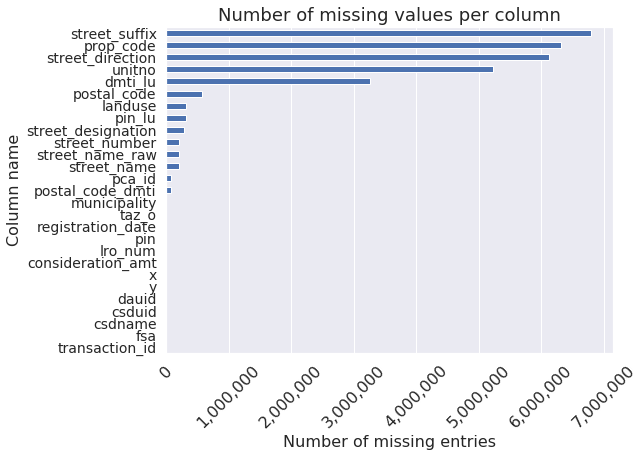

In [75]:
na_count = df.isnull().sum().sort_values()

f, ax = plt.subplots(1, figsize=(8, 6))
na_count.plot(kind='barh', ax=ax)
ax.grid(axis='y')
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=14)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Number of missing values per column", fontsize=18)
ax.set_ylabel("Column name", fontsize=16)
ax.set_xlabel("Number of missing entries", fontsize=16)
plt.savefig('results/teranet_na_count.png', dpi=400, bbox_inches='tight')

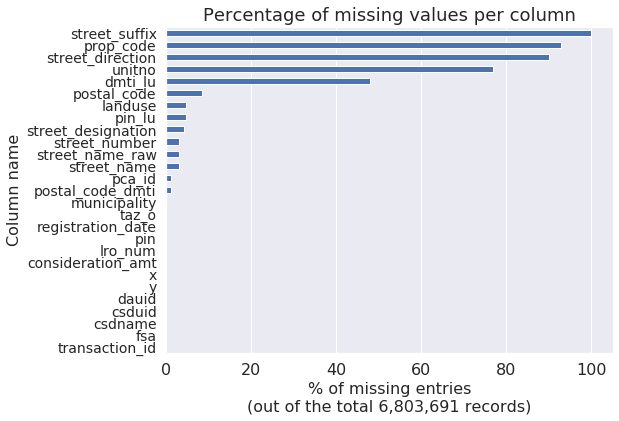

In [76]:
na_perc = df.isnull().sum().sort_values() / len(df) * 100

f, ax = plt.subplots(1, figsize=(8, 6))
na_perc.plot(kind='barh', ax=ax)
ax.grid(axis='y')
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Percentage of missing values per column", fontsize=18)
ax.set_ylabel("Column name", fontsize=16)
ax.set_xlabel("% of missing entries\n(out of the total {0:,} records)"
              .format(len(df)), fontsize=16)
plt.savefig('results/teranet_na_perc.png', dpi=400, bbox_inches='tight')

## Step 13: Remove column `street_suffix`
Since 99.99994% of the values in column `street_suffix` are missing, it has been removed from the dataset.

In [77]:
df = df.drop('street_suffix', axis=1)
print("Column 'street_suffix' was removed from the dataset.")

Column 'street_suffix' was removed from the dataset.


## Step 14: fix inconsistent values
Inconsistent entries are fixed in the following columns:
* Step 14.1: `street_direction`
* Step 14.2: `street_designaction`
* Step 14.3: `municipality`
* Step 14.4: `street_name`
* Step 14.5: `unitno`

### Step 14.1: Fix inconsistent values in column `street_direction`
Two Teranet records have `street_direction` = 'ES'. As it is unclear what should that correspond to (records correspond to the two transactions coming from some remote area north of Milton), their `street_direction` is reset to NaN (missing). Thus, `street_direction` for all Teranet records can be encoded as a singe character (catergory) that is either 'W', 'E', 'S', 'N', or NaN (missing).

In [78]:
df['street_direction'].value_counts()

W        316489
E        219818
N         70161
S         51637
West      11403
East       9193
North      2816
South      1607
N.          191
WEST        115
W.            6
E.            2
ES            2
NORTH         1
Name: street_direction, dtype: int64

#### Reset 'ES' to NaN

In [79]:
mask1 = df['street_direction'].str.match('ES', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

ES    2
Name: street_direction, dtype: int64

In [80]:
df.loc[mask1, 'street_direction'] = np.nan
df.loc[mask1, 'street_direction'].value_counts()

Series([], Name: street_direction, dtype: int64)

#### 'W'

In [81]:
mask1 = df['street_direction'].str.match('^W', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

W       316489
West     11403
WEST       115
W.           6
Name: street_direction, dtype: int64

In [82]:
df.loc[mask1, 'street_direction'] = 'W'
df.loc[mask1, 'street_direction'].value_counts()

W    328013
Name: street_direction, dtype: int64

#### 'E'

In [83]:
mask1 = df['street_direction'].str.match('^E', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

E       219818
East      9193
E.           2
Name: street_direction, dtype: int64

In [84]:
df.loc[mask1, 'street_direction'] = 'E'
df.loc[mask1, 'street_direction'].value_counts()

E    229013
Name: street_direction, dtype: int64

#### 'N'

In [85]:
mask1 = df['street_direction'].str.match('^N', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

N        70161
North     2816
N.         191
NORTH        1
Name: street_direction, dtype: int64

In [86]:
df.loc[mask1, 'street_direction'] = 'N'
df.loc[mask1, 'street_direction'].value_counts()

N    73169
Name: street_direction, dtype: int64

#### 'S'

In [87]:
mask1 = df['street_direction'].str.match('^S', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

S        51637
South     1607
Name: street_direction, dtype: int64

In [88]:
df.loc[mask1, 'street_direction'] = 'S'
df.loc[mask1, 'street_direction'].value_counts()

S    53244
Name: street_direction, dtype: int64

#### All inconsistent entries in column `street_direction` have been fixed.

In [89]:
df['street_direction'].value_counts()

W    328013
E    229013
N     73169
S     53244
Name: street_direction, dtype: int64

### Step 14.2: Fix inconsistent values in column `street_designation`
Street types were corrected in accordance with the [list of symbols and abbreviations](https://www.canadapost.ca/tools/pg/manual/PGaddress-e.asp?ecid=murl10006450) recognized by Canada Post. Only the values that needed correction are presented.

#### Abbey

In [90]:
mask1 = df['street_designation'].str.contains('Ab', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Abbey    11
Abe       4
Name: street_designation, dtype: int64

In [91]:
df.loc[mask1, 'street_designation'] = 'Abbey'
df.loc[mask1, 'street_designation'].value_counts()

Abbey    15
Name: street_designation, dtype: int64

#### Ave

In [92]:
mask1 = df['street_designation'].str.contains('Av', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Ave       1125986
Avenue      31474
Av           2061
Ave 5           2
Name: street_designation, dtype: int64

In [93]:
df.loc[mask1, 'street_designation'] = 'Ave'
df.loc[mask1, 'street_designation'].value_counts()

Ave    1159523
Name: street_designation, dtype: int64

#### Blvd

In [94]:
mask1 = df['street_designation'].str.contains('(bl|bo)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Blvd         325269
Boulevard     14041
Name: street_designation, dtype: int64

In [95]:
df.loc[mask1, 'street_designation'] = 'Blvd'
df.loc[mask1, 'street_designation'].value_counts()

Blvd    339310
Name: street_designation, dtype: int64

#### Cir

In [96]:
mask1 = df['street_designation'].str.contains('(cir$|circl)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Cir       133367
Circle      5616
Name: street_designation, dtype: int64

In [97]:
df.loc[mask1, 'street_designation'] = 'Cir'
df.loc[mask1, 'street_designation'].value_counts()

Cir    138983
Name: street_designation, dtype: int64

#### Crt

In [98]:
mask1 = df['street_designation'].str.contains('(Crt|Cou)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Crt      299387
Court     10876
Name: street_designation, dtype: int64

In [99]:
df.loc[mask1, 'street_designation'] = 'Crt'
df.loc[mask1, 'street_designation'].value_counts()

Crt    310263
Name: street_designation, dtype: int64

#### Cres

In [100]:
mask1 = df['street_designation'].str.contains('^Cre', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Cres        662212
Crescent     28068
Cresent         74
Name: street_designation, dtype: int64

In [101]:
df.loc[mask1, 'street_designation'] = 'Cres'
df.loc[mask1, 'street_designation'].value_counts()

Cres    690354
Name: street_designation, dtype: int64

#### Dell

In [102]:
mask1 = df['street_designation'].str.contains('^de', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Dell    19
De       2
Name: street_designation, dtype: int64

In [103]:
df.loc[mask1, 'street_designation'] = 'Dell'
df.loc[mask1, 'street_designation'].value_counts()

Dell    21
Name: street_designation, dtype: int64

#### Dr

In [104]:
mask1 = df['street_designation'].str.contains('Dr', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Dr          1076089
Drive         39475
Driveway       1997
Name: street_designation, dtype: int64

In [105]:
df.loc[mask1, 'street_designation'] = 'Dr'
df.loc[mask1, 'street_designation'].value_counts()

Dr    1117561
Name: street_designation, dtype: int64

#### Espl

In [106]:
mask1 = df['street_designation'].str.contains('^es', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Espl         8296
Esplanade    3487
Name: street_designation, dtype: int64

In [107]:
df.loc[mask1, 'street_designation'] = 'Espl'
df.loc[mask1, 'street_designation'].value_counts()

Espl    11783
Name: street_designation, dtype: int64

#### Landing

In [108]:
mask1 = df['street_designation'].str.contains('^land', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Landng     1272
Landing       2
Name: street_designation, dtype: int64

In [109]:
df.loc[mask1, 'street_designation'] = 'Landng'
df.loc[mask1, 'street_designation'].value_counts()

Landng    1274
Name: street_designation, dtype: int64

#### Lane

In [110]:
mask1 = df['street_designation'].str.contains('(lane|lanes|ln)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Lane     109029
Lanes        86
Ln           13
Name: street_designation, dtype: int64

In [111]:
df.loc[mask1, 'street_designation'] = 'Lane'
df.loc[mask1, 'street_designation'].value_counts()

Lane    109128
Name: street_designation, dtype: int64

#### Link

In [112]:
mask1 = df['street_designation'].str.contains('link', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Linkway    2458
Link         32
Name: street_designation, dtype: int64

In [113]:
df.loc[mask1, 'street_designation'] = 'Link'
df.loc[mask1, 'street_designation'].value_counts()

Link    2490
Name: street_designation, dtype: int64

#### Pky

In [114]:
mask1 = df['street_designation'].str.contains('(parkw|pky|pkwy)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Pky        20790
Pkwy           9
Parkway        8
Name: street_designation, dtype: int64

In [115]:
df.loc[mask1, 'street_designation'] = 'Pky'
df.loc[mask1, 'street_designation'].value_counts()

Pky    20807
Name: street_designation, dtype: int64

#### Pl

In [116]:
mask1 = df['street_designation'].str.contains('(^Pl$|Place)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Pl       117619
Place      2963
Name: street_designation, dtype: int64

In [117]:
df.loc[mask1, 'street_designation'] = 'Pl'
df.loc[mask1, 'street_designation'].value_counts()

Pl    120582
Name: street_designation, dtype: int64

#### Rd

In [118]:
mask1 = df['street_designation'].str.contains('(rd|roa)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Rd           884415
Road          48233
Sideroad       3685
Side rd        3118
Side road        83
Rd 30             5
Rd w              2
Name: street_designation, dtype: int64

In [119]:
df.loc[mask1, 'street_designation'] = 'Rd'
df.loc[mask1, 'street_designation'].value_counts()

Rd    939541
Name: street_designation, dtype: int64

#### St

In [120]:
mask1 = df['street_designation'].str.contains('^St', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

St        1018773
Street      47626
Name: street_designation, dtype: int64

In [121]:
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_designation'].value_counts()

St    1066399
Name: street_designation, dtype: int64

#### Sq

In [122]:
mask1 = df['street_designation'].str.contains('Sq', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Sq        47098
Square     1937
Name: street_designation, dtype: int64

In [123]:
df.loc[mask1, 'street_designation'] = 'Sq'
df.loc[mask1, 'street_designation'].value_counts()

Sq    49035
Name: street_designation, dtype: int64

#### Terr

In [124]:
mask1 = df['street_designation'].str.contains('Terr', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Terr       31332
Terrace     1147
Name: street_designation, dtype: int64

In [125]:
df.loc[mask1, 'street_designation'] = 'Terr'
df.loc[mask1, 'street_designation'].value_counts()

Terr    32479
Name: street_designation, dtype: int64

#### Terr

In [126]:
mask1 = df['street_designation'].str.contains('(Tra|Trl)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Trail    80732
Trl          4
Name: street_designation, dtype: int64

In [127]:
df.loc[mask1, 'street_designation'] = 'Trail'
df.loc[mask1, 'street_designation'].value_counts()

Trail    80736
Name: street_designation, dtype: int64

#### Vale

In [128]:
mask1 = df['street_designation'].str.contains('Val', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Vallee    105
Vale      101
Name: street_designation, dtype: int64

In [129]:
df.loc[mask1, 'street_designation'] = 'Vale'
df.loc[mask1, 'street_designation'].value_counts()

Vale    206
Name: street_designation, dtype: int64

#### Correct erratic entries: 48 refers to Highway 48

In [130]:
mask1 = df['street_designation'] == '48'
df[mask1]

,transaction_id,lro_num,pin,consideration_amt,registration_date,postal_code,unitno,street_name,street_designation,street_direction,...,csdname,taz_o,fsa,pca_id,postal_code_dmti,pin_lu,landuse,prop_code,dmti_lu,street_name_raw
1151023,1151023,65,35430323,295000.0,2006-11-15,NaN,NaN,Highway,48,NaN,...,Georgina,1348.0,L0E,180178265.0,L0E1R0,35430323.0,1.0,NaN,Open Area,Highway
2965303,2965303,65,35430323,270000.0,2003-03-05,NaN,NaN,Highway,48,NaN,...,Georgina,1348.0,L0E,180178265.0,L0E1R0,35430323.0,1.0,NaN,Open Area,Highway
3996729,3996729,65,35430323,315000.0,2013-05-30,NaN,NaN,Highway,48,NaN,...,Georgina,1348.0,L0E,180178265.0,L0E1R0,35430323.0,1.0,NaN,Open Area,Highway
6192171,6192171,65,35430323,280000.0,2009-08-07,NaN,NaN,Highway,48,NaN,...,Georgina,1348.0,L0E,180178265.0,L0E1R0,35430323.0,1.0,NaN,Open Area,Highway


In [131]:
df.loc[mask1, 'street_designation'] = 'Highway'
df.loc[mask1, 'street_name'] = 'Highway 48'
df.loc[mask1]

,transaction_id,lro_num,pin,consideration_amt,registration_date,postal_code,unitno,street_name,street_designation,street_direction,...,csdname,taz_o,fsa,pca_id,postal_code_dmti,pin_lu,landuse,prop_code,dmti_lu,street_name_raw
1151023,1151023,65,35430323,295000.0,2006-11-15,NaN,NaN,Highway 48,Highway,NaN,...,Georgina,1348.0,L0E,180178265.0,L0E1R0,35430323.0,1.0,NaN,Open Area,Highway
2965303,2965303,65,35430323,270000.0,2003-03-05,NaN,NaN,Highway 48,Highway,NaN,...,Georgina,1348.0,L0E,180178265.0,L0E1R0,35430323.0,1.0,NaN,Open Area,Highway
3996729,3996729,65,35430323,315000.0,2013-05-30,NaN,NaN,Highway 48,Highway,NaN,...,Georgina,1348.0,L0E,180178265.0,L0E1R0,35430323.0,1.0,NaN,Open Area,Highway
6192171,6192171,65,35430323,280000.0,2009-08-07,NaN,NaN,Highway 48,Highway,NaN,...,Georgina,1348.0,L0E,180178265.0,L0E1R0,35430323.0,1.0,NaN,Open Area,Highway


#### Correct erratic entries: Ctr refers to South Town Centre Blvd in Markham

In [132]:
mask1 = df['street_designation'].str.match('ctr', case=False, na=False)
df[mask1]

,transaction_id,lro_num,pin,consideration_amt,registration_date,postal_code,unitno,street_name,street_designation,street_direction,...,csdname,taz_o,fsa,pca_id,postal_code_dmti,pin_lu,landuse,prop_code,dmti_lu,street_name_raw
257086,257086,65,298440651,282320.0,2012-01-27,NaN,901,South Town,Ctr,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town
257106,257106,65,298440671,282320.0,2012-01-27,NaN,611,South Town,Ctr,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town
257135,257135,65,298440700,282320.0,2012-01-27,NaN,901,South Town,Ctr,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town
257398,257398,65,298440963,282320.0,2012-01-27,NaN,107,South Town,Ctr,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town
1828731,1828731,65,298440651,29000000.0,2007-12-18,NaN,901,South Town,Ctr,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town
1828751,1828751,65,298440671,29000000.0,2007-12-18,NaN,611,South Town,Ctr,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town
1828780,1828780,65,298440700,29000000.0,2007-12-18,NaN,901,South Town,Ctr,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town
1829043,1829043,65,298440963,29000000.0,2007-12-18,NaN,107,South Town,Ctr,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town
4173087,4173087,65,298440651,2.0,2012-06-01,NaN,901,South Town,Ctr,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town
4173107,4173107,65,298440671,2.0,2012-06-01,NaN,611,South Town,Ctr,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town


In [133]:
df.loc[mask1, 'street_designation'] = 'Blvd'
df.loc[mask1, 'street_name'] = 'South Town Centre'
df.loc[mask1]

,transaction_id,lro_num,pin,consideration_amt,registration_date,postal_code,unitno,street_name,street_designation,street_direction,...,csdname,taz_o,fsa,pca_id,postal_code_dmti,pin_lu,landuse,prop_code,dmti_lu,street_name_raw
257086,257086,65,298440651,282320.0,2012-01-27,NaN,901,South Town Centre,Blvd,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town
257106,257106,65,298440671,282320.0,2012-01-27,NaN,611,South Town Centre,Blvd,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town
257135,257135,65,298440700,282320.0,2012-01-27,NaN,901,South Town Centre,Blvd,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town
257398,257398,65,298440963,282320.0,2012-01-27,NaN,107,South Town Centre,Blvd,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town
1828731,1828731,65,298440651,29000000.0,2007-12-18,NaN,901,South Town Centre,Blvd,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town
1828751,1828751,65,298440671,29000000.0,2007-12-18,NaN,611,South Town Centre,Blvd,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town
1828780,1828780,65,298440700,29000000.0,2007-12-18,NaN,901,South Town Centre,Blvd,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town
1829043,1829043,65,298440963,29000000.0,2007-12-18,NaN,107,South Town Centre,Blvd,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town
4173087,4173087,65,298440651,2.0,2012-06-01,NaN,901,South Town Centre,Blvd,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town
4173107,4173107,65,298440671,2.0,2012-06-01,NaN,611,South Town Centre,Blvd,NaN,...,Markham,1176.0,L6G,180314134.0,L6G1E3,30339502.0,98.0,NaN,Resource and Industrial,South Town


#### All inconsistent entries in column `street_designation` have been fixed.

### Step 14.3: Fix inconsistent values in column `municipality`
`municipality` values were corrected in accordance with the 27 municipality names used for Dissemination Areas (DAs), as can be found in column `csdname` that was added to Teranet records via the spatial join performed during _Step 2.1_ of the cleanup process. Teranet records have a lot more different `municipality` names, such as 'York', 'East York', 'North York', 'Etobicoke', or smaller towns in GTHA, these values were left untouched; `municipality` names corresponding to major GTHA municipalities, that are used for DAs and can be found in column `csdname`, have been corrected to match the spelling found in Census datasets. 

In [134]:
df['csdname'].value_counts()

Toronto                          2785057
Mississauga                       703798
Brampton                          495970
Hamilton                          482655
Markham                           314783
Vaughan                           305211
Richmond Hill                     214837
Oakville                          210181
Burlington                        208953
Oshawa                            134040
Whitby                            110045
Milton                             94193
Ajax                               88102
Clarington                         86850
Caledon                            86725
Pickering                          86694
Newmarket                          73254
Halton Hills                       61429
Georgina                           59913
Aurora                             53802
Whitchurch-Stouffville             40717
King                               24894
Scugog                             23834
East Gwillimbury                   23568
Uxbridge        

### Toronto

In [135]:
mask1 = df['municipality'].str.contains('Toro', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Toronto               1778555
North York/Toronto        168
City Of Toronto            57
Islington/Toronto           3
Name: municipality, dtype: int64

In [136]:
df.loc[mask1, 'municipality'] = 'Toronto'
df.loc[mask1, 'municipality'].value_counts()

Toronto    1778783
Name: municipality, dtype: int64

### Mississauga

In [137]:
mask1 = df['municipality'].str.contains('Mis', na=False, case=False)
mask2 = df['municipality'].str.contains('\sof\s', na=False, case=False)
df.loc[mask1 & ~mask2, 'municipality'].value_counts()

Mississauga     703492
Mississsauga         2
Name: municipality, dtype: int64

In [138]:
df.loc[mask1 & ~mask2, 'municipality'] = 'Mississauga'
df.loc[mask1 & ~mask2, 'municipality'].value_counts()

Mississauga    703494
Name: municipality, dtype: int64

### Hamilton

In [139]:
mask1 = df['municipality'].str.contains('hami', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Hamilton            392099
Rural Hamilton        1214
City Of Hamilton       327
Hamilton City            2
Name: municipality, dtype: int64

In [140]:
df.loc[mask1, 'municipality'] = 'Hamilton'
df.loc[mask1, 'municipality'].value_counts()

Hamilton    393642
Name: municipality, dtype: int64

### Markham
#### Whit-Stouffville/Markham
Teranet records that have `municipality` value of 'Whit-Stouffville/Markham' are located in 'Whitchurch-Stouffville' according to their coordinates.

In [141]:
mask1 = df['municipality'] == 'Whit-Stouffville/Markham'
df.loc[mask1, ['municipality', 'csdname', 'y', 'x']]

,municipality,csdname,y,x
1602123,Whit-Stouffville/Markham,Whitchurch-Stouffville,43.936371,-79.380210
1847632,Whit-Stouffville/Markham,Whitchurch-Stouffville,43.936371,-79.380210
2198223,Whit-Stouffville/Markham,Whitchurch-Stouffville,44.083982,-79.343559
3132838,Whit-Stouffville/Markham,Whitchurch-Stouffville,43.974472,-79.231358


In [142]:
df.loc[mask1, 'municipality'] = 'Whitchurch-Stouffville'
df.loc[mask1, 'municipality'].value_counts()

Whitchurch-Stouffville    4
Name: municipality, dtype: int64

#### Markham

In [143]:
mask1 = df['municipality'].str.contains('markh', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Markham            258678
City Of Markham         6
Name: municipality, dtype: int64

In [144]:
df.loc[mask1, 'municipality'] = 'Markham'
df.loc[mask1, 'municipality'].value_counts()

Markham    258684
Name: municipality, dtype: int64

### Caledon

In [145]:
mask1 = df['municipality'].str.contains('(caledon$|caledon\s)', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Caledon            80549
Caledon East         338
Caledon Village       38
East Caledon           2
Name: municipality, dtype: int64

In [146]:
df.loc[mask1, 'municipality'] = 'Caledon'
df.loc[mask1, 'municipality'].value_counts()

Caledon    80927
Name: municipality, dtype: int64

### Pickering

In [147]:
mask1 = df['municipality'].str.contains('pick', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Pickering         86258
Pickering City        4
Name: municipality, dtype: int64

In [148]:
df.loc[mask1, 'municipality'] = 'Pickering'
df.loc[mask1, 'municipality'].value_counts()

Pickering    86262
Name: municipality, dtype: int64

### Newmarket

In [149]:
mask1 = df['municipality'].str.contains('newm', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Newmarket             71923
Newmarket Township     2310
Name: municipality, dtype: int64

In [150]:
df.loc[mask1, 'municipality'] = 'Newmarket'
df.loc[mask1, 'municipality'].value_counts()

Newmarket    74233
Name: municipality, dtype: int64

### Halton Hills
`municipality` value 'Halton' seems to correspond to a number of municipalities (Milton, Oakville, Halton Hills), as indicated by correcsponding values of `csdname`, and is left unchanged.

In [151]:
mask1 = df['municipality'].str.contains('halton\s', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Halton Hills    50528
Halton Hill         3
Name: municipality, dtype: int64

In [152]:
df.loc[mask1, 'municipality'] = 'Halton Hills'
df.loc[mask1, 'municipality'].value_counts()

Halton Hills    50531
Name: municipality, dtype: int64

### Georgina

In [153]:
mask1 = df['municipality'].str.contains('georgi', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Georgina            35308
Town Of Georgina        9
Name: municipality, dtype: int64

In [154]:
df.loc[mask1, 'municipality'] = 'Georgina'
df.loc[mask1, 'municipality'].value_counts()

Georgina    35317
Name: municipality, dtype: int64

### Whitchurch-Stouffville

In [155]:
mask1 = df['municipality'].str.contains('(whitc|stou)', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Whitchurch-Stouffville      20264
Stouffville                 16652
Whitchurch - Stouffville     2758
Whitchurch/Stouffville         23
Whitchurch                      2
Name: municipality, dtype: int64

In [156]:
df.loc[mask1, 'municipality'] = 'Whitchurch-Stouffville'
df.loc[mask1, 'municipality'].value_counts()

Whitchurch-Stouffville    39699
Name: municipality, dtype: int64

### King

In [157]:
mask1 = df['municipality'].str.contains('(king$|king\s)', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

King             10246
King City         6874
King Township     2699
Name: municipality, dtype: int64

In [158]:
df.loc[mask1, 'municipality'] = 'King'
df.loc[mask1, 'municipality'].value_counts()

King    19819
Name: municipality, dtype: int64

### Scugog

In [159]:
mask1 = df['municipality'].str.contains('scu', na=False, case=False)
mask2 = df['municipality'].str.contains('mississ', na=False, case=False)
df.loc[mask1 & ~mask2, 'municipality'].value_counts()

Scugog             16005
Scugog Township     2445
Name: municipality, dtype: int64

In [160]:
df.loc[mask1, 'municipality'] = 'Scugog'
df.loc[mask1, 'municipality'].value_counts()

Scugog    18456
Name: municipality, dtype: int64

### Uxbridge

In [161]:
mask1 = df['municipality'].str.contains('ux', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Uxbridge             18704
Uxbridge Township     1641
Name: municipality, dtype: int64

In [162]:
df.loc[mask1, 'municipality'] = 'Uxbridge'
df.loc[mask1, 'municipality'].value_counts()

Uxbridge    20345
Name: municipality, dtype: int64

### Brock

In [163]:
mask1 = df['municipality'].str.contains('brock$|brock\s', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Brock             7622
Brock Township    3953
Name: municipality, dtype: int64

In [164]:
df.loc[mask1, 'municipality'] = 'Brock'
df.loc[mask1, 'municipality'].value_counts()

Brock    11575
Name: municipality, dtype: int64

### Step 14.4: Inconsistent values in column `street_name`
Consistency of entries in column `street_name` was improved through parsing out zip codes, unit and street numbers, street directions and street designations in the previous steps. Corrections for most frequently encountered street names are made in this subsection.

In [165]:
df['street_name'].value_counts()

Yonge                      82528
King                       46727
Sheppard                   36154
Bay                        35939
Lakeshore                  32420
                           ...  
St Hubertave                   1
Hollinsworth                   1
Education Road (Part)          1
& 36 Anderson Boulevard        1
Joyce Parkway                  1
Name: street_name, Length: 28746, dtype: int64

#### Yonge St

In [166]:
mask1 = df['street_name'].str.contains('yonge\ss', na=False, case=False)
mask2 = df['street_name'].str.contains('(,|Tower|\/)', na=False, case=False)
df.loc[mask1 & ~mask2, 'street_name'].value_counts()

Yonge Street                       89
Yonge Steet                         6
Yonge Street South Of Ravenshoe     5
Yonge Stree                         5
Yonge Street Ric                    2
Yonge Strret                        1
Yonge Steeet                        1
Yonge Sstreet                       1
Name: street_name, dtype: int64

In [167]:
df.loc[mask1 & ~mask2, 'street_name'] = 'Yonge'
df.loc[mask1 & ~mask2, 'street_designation'] = 'St'
df.loc[mask1 & ~mask2, 'street_name'].value_counts()

Yonge    110
Name: street_name, dtype: int64

#### King St

In [168]:
mask1 = df['street_name'].str.contains('king\sstreet$|king\sst$|king\sst\.|king\sstreet,$', na=False, case=False)
df.loc[mask1, 'street_name'].value_counts()

King Street     40
King St          8
King St.         3
King Street,     2
Name: street_name, dtype: int64

In [169]:
df.loc[mask1, 'street_name'] = 'King'
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_name'].value_counts()

King    53
Name: street_name, dtype: int64

#### Sheppard Ave

##### Fix street directions

In [170]:
mask1 = df['street_name'] == "Sheppard AveE."
df.loc[mask1, ['unitno', 'street_number', 'street_name', 'street_direction', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_direction,municipality,y,x
70107,NaN,180,Sheppard AveE.,NaN,Willowdale,43.763622,-79.402599
338144,NaN,218,Sheppard AveE.,NaN,Willowdale,43.763952,-79.401102
493000,NaN,200,Sheppard AveE.,NaN,Willowdale,43.763833,-79.401759
692678,NaN,166,Sheppard AveE.,NaN,Willowdale,43.764131,-79.404090
1598345,NaN,200,Sheppard AveE.,NaN,Willowdale,43.763833,-79.401759
1768215,NaN,200,Sheppard AveE.,NaN,Willowdale,43.763833,-79.401759
1778842,NaN,218,Sheppard AveE.,NaN,Willowdale,43.763952,-79.401102
2214467,NaN,200,Sheppard AveE.,NaN,Willowdale,43.763833,-79.401759
2674269,NaN,222,Sheppard AveE.,NaN,Willowdale,43.764049,-79.400651
2986783,NaN,166,Sheppard AveE.,NaN,Willowdale,43.764131,-79.404090


In [171]:
df.loc[mask1, 'street_direction'] = 'E'
df.loc[mask1, ['unitno', 'street_number', 'street_name', 'street_direction', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_direction,municipality,y,x
70107,NaN,180,Sheppard AveE.,E,Willowdale,43.763622,-79.402599
338144,NaN,218,Sheppard AveE.,E,Willowdale,43.763952,-79.401102
493000,NaN,200,Sheppard AveE.,E,Willowdale,43.763833,-79.401759
692678,NaN,166,Sheppard AveE.,E,Willowdale,43.764131,-79.404090
1598345,NaN,200,Sheppard AveE.,E,Willowdale,43.763833,-79.401759
1768215,NaN,200,Sheppard AveE.,E,Willowdale,43.763833,-79.401759
1778842,NaN,218,Sheppard AveE.,E,Willowdale,43.763952,-79.401102
2214467,NaN,200,Sheppard AveE.,E,Willowdale,43.763833,-79.401759
2674269,NaN,222,Sheppard AveE.,E,Willowdale,43.764049,-79.400651
2986783,NaN,166,Sheppard AveE.,E,Willowdale,43.764131,-79.404090


In [172]:
mask1 = df['street_name'] == "Sheppard AveW."
df.loc[mask1, ['unitno', 'street_number', 'street_name', 'street_direction', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_direction,municipality,y,x
3627150,NaN,137,Sheppard AveW.,NaN,North York,43.759712,-79.417744
3914665,NaN,115,Sheppard AveW.,NaN,North York,43.759937,-79.416730
5240117,NaN,133,Sheppard AveW.,NaN,Willowdale,43.759736,-79.417652
5332745,NaN,115,Sheppard AveW.,NaN,North York,43.759937,-79.416730
6594312,NaN,109,Sheppard AveW.,NaN,North York,43.760000,-79.416439


In [173]:
df.loc[mask1, 'street_direction'] = 'W'
df.loc[mask1, ['unitno', 'street_number', 'street_name', 'street_direction', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_direction,municipality,y,x
3627150,NaN,137,Sheppard AveW.,W,North York,43.759712,-79.417744
3914665,NaN,115,Sheppard AveW.,W,North York,43.759937,-79.416730
5240117,NaN,133,Sheppard AveW.,W,Willowdale,43.759736,-79.417652
5332745,NaN,115,Sheppard AveW.,W,North York,43.759937,-79.416730
6594312,NaN,109,Sheppard AveW.,W,North York,43.760000,-79.416439


##### Fix street name and street designation

In [174]:
mask1 = df['street_name'].str.contains('sheppard av', na=False, case=False)
mask2 = df['street_name'].str.contains('\(', na=False, case=False)
df.loc[mask1 & ~mask2, 'street_name'].value_counts()

Sheppard Avenue    91
Sheppard AveE.     13
Sheppard Ave        7
Sheppard AveW.      5
Name: street_name, dtype: int64

In [175]:
df.loc[mask1, 'street_name'] = 'Sheppard'
df.loc[mask1, 'street_designation'] = 'Ave'
df.loc[mask1, 'street_name'].value_counts()

Sheppard    119
Name: street_name, dtype: int64

#### Bloor St

##### Fix street number

In [176]:
mask1 = df['street_name'].str.contains('^bloor\ss', na=False, case=False)
mask2 = df['street_name'].str.contains('\se', na=False, case=False)
mask3 = df['street_name'].str.contains('#', na=False)
df.loc[mask1 & mask2 & mask3, 'street_name'].value_counts()

Bloor Street East, #807    1
Name: street_name, dtype: int64

In [177]:
df.loc[mask1 & mask2 & mask3, 'street_number'] = 807
print("Street number fixed!")

Street number fixed!


##### Fix street direction

In [178]:
mask1 = df['street_name'].str.contains('^bloor\ss', na=False, case=False)
mask2 = df['street_name'].str.contains('\se', na=False, case=False)
df.loc[mask1 & mask2, 'street_name'].value_counts()

Bloor St Est               2
Bloor Street Est           1
Bloor Street East`         1
Bloor Street East, #807    1
Name: street_name, dtype: int64

In [179]:
df.loc[mask1 & mask2, 'street_direction'] = 'E'
print("Street direction fixed!")

Street direction fixed!


##### Fix street name and street designation

In [180]:
mask1 = df['street_name'].str.contains('^bloor\ss', na=False, case=False)
df.loc[mask1, 'street_name'].value_counts()

Bloor Streest              3
Bloor Sreet                2
Bloor St Est               2
Bloor Stree                2
Bloor Street Est           1
Bloor Street East`         1
Bloor Street East, #807    1
Bloor Streeat              1
Bloor Street,              1
Bloor Strret               1
Name: street_name, dtype: int64

In [181]:
df.loc[mask1, 'street_name'] = 'Bloor'
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_name'].value_counts()

Bloor    15
Name: street_name, dtype: int64

#### Dundas St

In [182]:
mask1 = df['street_name'].str.contains('^Dundas\ss$|^dundas\sst', na=False, case=False)
df.loc[mask1, 'street_name'].value_counts()

Dundas Street        21
Dundas St.            3
Dundas Street,        2
Dundas St E Hwy 5     1
Dundas St             1
Dundas S              1
Name: street_name, dtype: int64

In [183]:
df.loc[mask1, 'street_name'] = 'Dundas'
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_name'].value_counts()

Dundas    29
Name: street_name, dtype: int64

#### Front St

In [184]:
mask1 = df['street_name'].str.contains('Front\s', na=False, case=False)
df.loc[mask1, 'street_name'].value_counts()

Front Stree      1
Front Stereet    1
Front Street,    1
Name: street_name, dtype: int64

In [185]:
df.loc[mask1, 'street_name'] = 'Front'
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_name'].value_counts()

Front    3
Name: street_name, dtype: int64

There are many more inconsistencies present in column `street_name`, but since fixing all of them presents a time-intensive task, it is left until a future stage when targeted corrections can be performed where required.

### Step 14.5: Fix values in column `unitno`

#### 1.010000e-107

In [186]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.01')
mask3 = unit_no.str.match('1.009')
df.loc[mask1 & (mask2 | mask3), 'unitno']

1466833    1.01e-107
Name: unitno, dtype: object

In [187]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 101
df.loc[mask1 & (mask2 | mask3), 'unitno']

1466833    101
Name: unitno, dtype: object

#### 1.200000e-/+x
>It is impossible to tell, if this erratic unit number corresponds to '12', '120', or '1200'. All units that match this pattern have been converted to '12'.

In [188]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.199')
df.loc[mask1 & mask2, 'unitno']

1895231    1.2e-103
2151587    1.2e-103
2151635    1.2e-200
2151636    1.2e-200
2151637    1.2e-200
2151638    1.2e-200
2258365    1.2e-103
2258413    1.2e-200
2258414    1.2e-200
2258415    1.2e-200
2258416    1.2e-200
2855024    1.2e-103
4907740    1.2e-200
4907741    1.2e-200
4907742    1.2e-200
4907743    1.2e-200
Name: unitno, dtype: object

In [189]:
df.loc[mask1 & mask2, 'unitno'] = 12
df.loc[mask1 & mask2, 'unitno']

1895231    12
2151587    12
2151635    12
2151636    12
2151637    12
2151638    12
2258365    12
2258413    12
2258414    12
2258415    12
2258416    12
2855024    12
4907740    12
4907741    12
4907742    12
4907743    12
Name: unitno, dtype: object

#### 2.000000e-/+x
>It is impossible to tell, if this erratic unit number corresponds to '2', '20', or '200'. All units that match this pattern have been converted to '2'.

In [190]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('2')
mask3 = unit_no.str.match('1.99')
df.loc[mask1 & (mask2 | mask3), 'unitno']

136130     2e-123
621155     2e+155
1287375    2e+155
1661701     2e-12
2194450     2e-22
2413856     2e-22
2886166     2e-12
3099409    2e-123
3207430     2e-22
3382886     2e-06
3628932    2e+105
3787257     2e-12
4121678    2e+105
4287933     2e+21
4287934     2e+19
4287935     2e+18
4443243     2e-05
4923062     2e+21
4923063     2e+19
4923064     2e+18
5232149     2e-06
5997426    2e-123
Name: unitno, dtype: object

In [191]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 2
df.loc[mask1 & (mask2 | mask3), 'unitno']

136130     2
621155     2
1287375    2
1661701    2
2194450    2
2413856    2
2886166    2
3099409    2
3207430    2
3382886    2
3628932    2
3787257    2
4121678    2
4287933    2
4287934    2
4287935    2
4443243    2
4923062    2
4923063    2
4923064    2
5232149    2
5997426    2
Name: unitno, dtype: object

#### 1.100000e-201
>It is impossible to tell, if this erratic unit number corresponds to '11', '110', or '1100'. All units that match this pattern have been converted to '11'.

In [192]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.1')
mask3 = unit_no.str.match('1.09')
df.loc[mask1 & (mask2 | mask3), 'unitno']

223667     1.1e-201
223668     1.1e-201
223669     1.1e-201
2151652    1.1e-201
2151653    1.1e-201
2151654    1.1e-201
2152682    1.1e-201
2152683    1.1e-201
2152684    1.1e-201
2258430    1.1e-201
2258431    1.1e-201
2258432    1.1e-201
Name: unitno, dtype: object

In [193]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 11
df.loc[mask1 & (mask2 | mask3), 'unitno']

223667     11
223668     11
223669     11
2151652    11
2151653    11
2151654    11
2152682    11
2152683    11
2152684    11
2258430    11
2258431    11
2258432    11
Name: unitno, dtype: object

#### 1.700000e-06
>It is impossible to tell, if this erratic unit number corresponds to '17', '170', or '1700'. All units that match this pattern have been converted to '17'.

In [194]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.7')
mask3 = unit_no.str.match('1.69')
df.loc[mask1 & (mask2 | mask3), 'unitno']

2544009    1.7e-06
6599612    1.7e-06
Name: unitno, dtype: object

In [195]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 17
df.loc[mask1 & (mask2 | mask3), 'unitno']

2544009    17
6599612    17
Name: unitno, dtype: object

#### 1.800000e-19
>It is impossible to tell, if this erratic unit number corresponds to '18', '180', or '1800'. All units that match this pattern have been converted to '18'.

In [196]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.8')
mask3 = unit_no.str.match('1.79')
df.loc[mask1 & (mask2 | mask3), 'unitno']

2580783    1.8e-19
Name: unitno, dtype: object

In [197]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 18
df.loc[mask1 & (mask2 | mask3), 'unitno']

2580783    18
Name: unitno, dtype: object

#### 3.300000e-33
>It is impossible to tell, if this erratic unit number corresponds to '33', '330', or '3300'. All units that match this pattern have been converted to '33'.

In [198]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('3.3')
mask3 = unit_no.str.match('3.29')
df.loc[mask1 & (mask2 | mask3), 'unitno']

529785     3.3e-33
3525815    3.3e-33
4957441    3.3e-33
Name: unitno, dtype: object

In [199]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 33
df.loc[mask1 & (mask2 | mask3), 'unitno']

529785     33
3525815    33
4957441    33
Name: unitno, dtype: object

#### 6.000000e-x
>It is impossible to tell, if this erratic unit number corresponds to '6', '60', or '600'. All units that match this pattern have been converted to '6'.

In [200]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('6')
mask3 = unit_no.str.match('5.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

1152118    6e-201
1152119    6e-201
1152120    6e-201
1152121    6e-201
1152122    6e-201
2151548    6e-104
2151549    6e-104
2151566    6e-201
2151567    6e-201
2151568    6e-201
2151569    6e-201
2151570    6e-201
2258333    6e-104
2258334    6e-104
2258344    6e-201
2258345    6e-201
2258346    6e-201
2258347    6e-201
2258348    6e-201
2669197    6e-104
2669198    6e-104
3352575    6e-104
3352576    6e-104
3694391     6e-22
4102832     6e-22
Name: unitno, dtype: object

In [201]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 6
df.loc[mask1 & (mask2 | mask3), 'unitno']

1152118    6
1152119    6
1152120    6
1152121    6
1152122    6
2151548    6
2151549    6
2151566    6
2151567    6
2151568    6
2151569    6
2151570    6
2258333    6
2258334    6
2258344    6
2258345    6
2258346    6
2258347    6
2258348    6
2669197    6
2669198    6
3352575    6
3352576    6
3694391    6
4102832    6
Name: unitno, dtype: object

#### 5.000000e-x
>It is impossible to tell, if this erratic unit number corresponds to '5', '50', or '500'. All units that match this pattern have been converted to '5'.

In [202]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('5')
mask3 = unit_no.str.match('4.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

1895228    5e-102
1895229    5e-102
2151537    5e-103
2151538    5e-103
2151543    5e-102
2151544    5e-102
2258322    5e-103
2258323    5e-103
2258328    5e-102
2258329    5e-102
4345814    5e-103
4345815    5e-103
6308294     5e-06
6308295     5e-06
Name: unitno, dtype: object

In [203]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 5
df.loc[mask1 & (mask2 | mask3), 'unitno']

1895228    5
1895229    5
2151537    5
2151538    5
2151543    5
2151544    5
2258322    5
2258323    5
2258328    5
2258329    5
4345814    5
4345815    5
6308294    5
6308295    5
Name: unitno, dtype: object

#### 1.000000e-/+21
>It is impossible to tell, if this erratic unit number corresponds to '1', '10', or '100'. All units that match this pattern have been converted to '1'.

In [204]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1')
mask3 = unit_no.str.match('0.9')
id_list = [3953792, 3954603, 3954834]
mask4 = unit_no.index.isin(id_list)
df.loc[mask1 & (mask2 | mask3) | mask4, 'unitno']

807543     1e+27
807544     1e+25
807545     1e+22
807546     1e+20
807547     1e+18
1590917    1e-10
1903937    1e-20
1903942    1e-20
2557352    1e-20
2977023    1e-10
3036797    1e+17
3036798    1e+19
3036799    1e+21
3036800    1e+23
3122350    1e+26
3402576    1e-05
3402577    1e-05
3402578    1e-05
3402579    1e-05
3402580    1e-05
3953792      607
3954603      NaN
3954834      NaN
4262536    1e-10
4890839    1e+21
4923040    1e+17
4923041    1e+19
4923042    1e+21
4923043    1e+27
4923044    1e+25
4923045    1e+22
4923046    1e+20
4923047    1e+18
4999364    1e+23
4999365    1e+26
5017412    1e+17
5017426    1e+16
5666859    1e+19
5742157    1e+17
6257226    1e-10
6273793    1e+26
Name: unitno, dtype: object

In [205]:
df.loc[mask1 & (mask2 | mask3) | mask4, 'unitno'] = 1
df.loc[mask1 & (mask2 | mask3) | mask4, 'unitno']

807543     1
807544     1
807545     1
807546     1
807547     1
1590917    1
1903937    1
1903942    1
2557352    1
2977023    1
3036797    1
3036798    1
3036799    1
3036800    1
3122350    1
3402576    1
3402577    1
3402578    1
3402579    1
3402580    1
3953792    1
3954603    1
3954834    1
4262536    1
4890839    1
4923040    1
4923041    1
4923042    1
4923043    1
4923044    1
4923045    1
4923046    1
4923047    1
4999364    1
4999365    1
5017412    1
5017426    1
5666859    1
5742157    1
6257226    1
6273793    1
Name: unitno, dtype: object

#### 9.000000e-104
>It is impossible to tell, if this erratic unit number corresponds to '9', '90', or '900'. All units that match this pattern have been converted to '9'.

In [206]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('9')
mask3 = unit_no.str.match('8.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

7460       9e-104
1458898    9e-104
1978802    9e-104
2151517    1e-101
2151610    9e-104
2258302    1e-101
2258388    9e-104
3057017    9e-104
4874618    1e-101
5893554    9e-104
Name: unitno, dtype: object

In [207]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 9
df.loc[mask1 & (mask2 | mask3), 'unitno']

7460       9
1458898    9
1978802    9
2151517    9
2151610    9
2258302    9
2258388    9
3057017    9
4874618    9
5893554    9
Name: unitno, dtype: object

#### 4.000000e-104
>It is impossible to tell, if this erratic unit number corresponds to '4', '40', or '400'. All units that match this pattern have been converted to '4'.

In [208]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('4')
mask3 = unit_no.str.match('3.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

1895230    4e-104
2151582    4e-104
2258360    4e-104
2795250    4e-104
Name: unitno, dtype: object

In [209]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 4
df.loc[mask1 & (mask2 | mask3), 'unitno']

1895230    4
2151582    4
2258360    4
2795250    4
Name: unitno, dtype: object

#### 0.01

In [210]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.01')
df.loc[mask1, 'unitno']

681723     0.01
1320664    0.01
5535408    0.01
6339720    0.01
6778213    0.01
Name: unitno, dtype: object

In [211]:
df.loc[mask1, 'unitno'] = 1
df.loc[mask1, 'unitno']

681723     1
1320664    1
5535408    1
6339720    1
6778213    1
Name: unitno, dtype: object

#### 0.37

In [212]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.37')
df.loc[mask1, 'unitno']

3265731    0.37
3488234    0.37
3742315    0.37
4661200    0.37
4751527    0.37
Name: unitno, dtype: object

In [213]:
df.loc[mask1, 'unitno'] = 37
df.loc[mask1, 'unitno']

3265731    37
3488234    37
3742315    37
4661200    37
4751527    37
Name: unitno, dtype: object

#### 0.000815

In [214]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.000815')
df.loc[mask1, 'unitno']

3971974    0.000815
3971975    0.000815
4851880    0.000815
4851881    0.000815
Name: unitno, dtype: object

In [215]:
df.loc[mask1, 'unitno'] = 815
df.loc[mask1, 'unitno']

3971974    815
3971975    815
4851880    815
4851881    815
Name: unitno, dtype: object

#### 0.033

In [216]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.033')
df.loc[mask1, 'unitno']

671680    0.033
Name: unitno, dtype: object

In [217]:
df.loc[mask1, 'unitno'] = 33
df.loc[mask1, 'unitno']

671680    33
Name: unitno, dtype: object

#### 0.24

In [218]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.24')
df.loc[mask1, 'unitno']

2489134    0.24
4663903    0.24
5542650    0.24
6717517    0.24
Name: unitno, dtype: object

In [219]:
df.loc[mask1, 'unitno'] = 24
df.loc[mask1, 'unitno']

2489134    24
4663903    24
5542650    24
6717517    24
Name: unitno, dtype: object

#### 0.2

In [220]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.2')
df.loc[mask1, 'unitno']

297853     0.2
413066     0.2
1445507    0.2
1661699    0.2
1818574    0.2
2222589    0.2
2278029    0.2
2647419    0.2
3257222    0.2
3364099    0.2
4034433    0.2
4057876    0.2
4208416    0.2
4292999    0.2
4360940    0.2
4626478    0.2
4961515    0.2
4961516    0.2
5543865    0.2
6157226    0.2
6549447    0.2
6552449    0.2
6698646    0.2
Name: unitno, dtype: object

In [221]:
df.loc[mask1, 'unitno'] = 2
df.loc[mask1, 'unitno']

297853     2
413066     2
1445507    2
1661699    2
1818574    2
2222589    2
2278029    2
2647419    2
3257222    2
3364099    2
4034433    2
4057876    2
4208416    2
4292999    2
4360940    2
4626478    2
4961515    2
4961516    2
5543865    2
6157226    2
6549447    2
6552449    2
6698646    2
Name: unitno, dtype: object

#### 0.003

In [222]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.003')
df.loc[mask1, 'unitno']

219562     0.003
512818     0.003
731727     0.003
1696827    0.003
1718094    0.003
1994651    0.003
2715894    0.003
3117423    0.003
3382471    0.003
Name: unitno, dtype: object

In [223]:
df.loc[mask1, 'unitno'] = 3
df.loc[mask1, 'unitno']

219562     3
512818     3
731727     3
1696827    3
1718094    3
1994651    3
2715894    3
3117423    3
3382471    3
Name: unitno, dtype: object

#### 0.04

In [224]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.04')
df.loc[mask1, 'unitno']

1661697    0.04
3878585    0.04
Name: unitno, dtype: object

In [225]:
df.loc[mask1, 'unitno'] = 4
df.loc[mask1, 'unitno']

1661697    4
3878585    4
Name: unitno, dtype: object

#### 0.001

In [226]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.001')
df.loc[mask1, 'unitno']

329537     0.001
1038641    0.001
1391224    0.001
1391225    0.001
1391226    0.001
1937899    0.001
1937900    0.001
Name: unitno, dtype: object

In [227]:
df.loc[mask1, 'unitno'] = 1
df.loc[mask1, 'unitno']

329537     1
1038641    1
1391224    1
1391225    1
1391226    1
1937899    1
1937900    1
Name: unitno, dtype: object

#### 0.0026

In [228]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.0026')
df.loc[mask1, 'unitno']

3369568    0.0026
5572277    0.0026
6239068    0.0026
Name: unitno, dtype: object

In [229]:
df.loc[mask1, 'unitno'] = 26
df.loc[mask1, 'unitno']

3369568    26
5572277    26
6239068    26
Name: unitno, dtype: object

#### 0.0024

In [230]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.0024')
df.loc[mask1, 'unitno']

2543985    0.0024
6599611    0.0024
Name: unitno, dtype: object

In [231]:
df.loc[mask1, 'unitno'] = 24
df.loc[mask1, 'unitno']

2543985    24
6599611    24
Name: unitno, dtype: object

#### 0.66

In [232]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.66')
df.loc[mask1, 'unitno']

327521     0.66
1849044    0.66
2378921    0.66
3999576    0.66
6584968    0.66
Name: unitno, dtype: object

In [233]:
df.loc[mask1, 'unitno'] = 66
df.loc[mask1, 'unitno']

327521     66
1849044    66
2378921    66
3999576    66
6584968    66
Name: unitno, dtype: object

#### 0.83

In [234]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.83')
df.loc[mask1, 'unitno']

1187395    0.83
2563193    0.83
3031083    0.83
Name: unitno, dtype: object

In [235]:
df.loc[mask1, 'unitno'] = 83
df.loc[mask1, 'unitno']

1187395    83
2563193    83
3031083    83
Name: unitno, dtype: object

#### 3.01

In [236]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^3\.01$')
df.loc[mask1, 'unitno']

1233341    3.01
1233342    3.01
1233343    3.01
1233344    3.01
6630390    3.01
6630391    3.01
6630392    3.01
6630393    3.01
Name: unitno, dtype: object

In [237]:
df.loc[mask1, 'unitno'] = 301
df.loc[mask1, 'unitno']

1233341    301
1233342    301
1233343    301
1233344    301
6630390    301
6630391    301
6630392    301
6630393    301
Name: unitno, dtype: object

#### 1.5

In [238]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^1.5$')
df.loc[mask1, 'unitno']

3700456    1.5
3727061    1.5
Name: unitno, dtype: object

In [239]:
df.loc[mask1, 'unitno'] = 15
df.loc[mask1, 'unitno']

3700456    15
3727061    15
Name: unitno, dtype: object

#### 1.6

In [240]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^1\.6$')
df.loc[mask1, 'unitno']

3700457    1.6
3727062    1.6
Name: unitno, dtype: object

In [241]:
df.loc[mask1, 'unitno'] = 16
df.loc[mask1, 'unitno']

3700457    16
3727062    16
Name: unitno, dtype: object

#### 4.2

In [242]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^4\.2$')
df.loc[mask1, 'unitno']

4054319    4.2
4575900    4.2
Name: unitno, dtype: object

In [243]:
df.loc[mask1, 'unitno'] = 42
df.loc[mask1, 'unitno']

4054319    42
4575900    42
Name: unitno, dtype: object

#### 7.9

In [244]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^7\.9$')
df.loc[mask1, 'unitno']

2743859    7.9
5176961    7.9
Name: unitno, dtype: object

In [245]:
df.loc[mask1, 'unitno'] = 79
df.loc[mask1, 'unitno']

2743859    79
5176961    79
Name: unitno, dtype: object

#### 1.9

In [246]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^1\.9$')
df.loc[mask1, 'unitno']

736453     1.9
776458     1.9
3574733    1.9
Name: unitno, dtype: object

In [247]:
df.loc[mask1, 'unitno'] = 19
df.loc[mask1, 'unitno']

736453     19
776458     19
3574733    19
Name: unitno, dtype: object

#### 9.5

In [248]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^9\.5$')
df.loc[mask1, 'unitno']

686784     9.5
888164     9.5
954367     9.5
6011893    9.5
Name: unitno, dtype: object

In [249]:
df.loc[mask1, 'unitno'] = 95
df.loc[mask1, 'unitno']

686784     95
888164     95
954367     95
6011893    95
Name: unitno, dtype: object

#### 0.02, 0.002, and 0.0002

In [250]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^0')
mask2 = unit_no.str.contains('2')
df.loc[mask1 & mask2, 'unitno']

2942102      0.02
3257223     0.002
4080997      0.02
4220176    0.0002
Name: unitno, dtype: object

In [251]:
df.loc[mask1 & mask2, 'unitno'] = 2
df.loc[mask1 & mask2, 'unitno']

2942102    2
3257223    2
4080997    2
4220176    2
Name: unitno, dtype: object

#### 4.7

In [252]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^4\.7$')
df.loc[mask1, 'unitno']

671631    4.7
Name: unitno, dtype: object

In [253]:
df.loc[mask1, 'unitno'] = 47
df.loc[mask1, 'unitno']

671631    47
Name: unitno, dtype: object

#### 6.5

In [254]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^6\.5$')
df.loc[mask1, 'unitno']

307388    6.5
Name: unitno, dtype: object

In [255]:
df.loc[mask1, 'unitno'] = 65
df.loc[mask1, 'unitno']

307388    65
Name: unitno, dtype: object

#### 3.5

In [256]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^3\.5$')
df.loc[mask1, 'unitno']

307387    3.5
Name: unitno, dtype: object

In [257]:
df.loc[mask1, 'unitno'] = 35
df.loc[mask1, 'unitno']

307387    35
Name: unitno, dtype: object

#### 16.9

In [258]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16\.9$')
df.loc[mask1, 'unitno']

1496194    16.9
3051673    16.9
5835491    16.9
Name: unitno, dtype: object

In [259]:
df.loc[mask1, 'unitno'] = 169
df.loc[mask1, 'unitno']

1496194    169
3051673    169
5835491    169
Name: unitno, dtype: object

#### 10.4

In [260]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^10\.4$')
df.loc[mask1, 'unitno']

4406734    10.4
6223896    10.4
Name: unitno, dtype: object

In [261]:
df.loc[mask1, 'unitno'] = 104
df.loc[mask1, 'unitno']

4406734    104
6223896    104
Name: unitno, dtype: object

#### 17.2

In [262]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^17\.2$')
df.loc[mask1, 'unitno']

5017355    17.2
5022497    17.2
Name: unitno, dtype: object

In [263]:
df.loc[mask1, 'unitno'] = 172
df.loc[mask1, 'unitno']

5017355    172
5022497    172
Name: unitno, dtype: object

#### 16.2

In [264]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16\.2$')
df.loc[mask1, 'unitno']

3119589    16.2
Name: unitno, dtype: object

In [265]:
df.loc[mask1, 'unitno'] = 162
df.loc[mask1, 'unitno']

3119589    162
Name: unitno, dtype: object

#### 16.1

In [266]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16\.1$')
df.loc[mask1, 'unitno']

6421542    16.1
Name: unitno, dtype: object

In [267]:
df.loc[mask1, 'unitno'] = 161
df.loc[mask1, 'unitno']

6421542    161
Name: unitno, dtype: object

#### 16.5

In [268]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16\.5$')
df.loc[mask1, 'unitno']

797823    16.5
Name: unitno, dtype: object

In [269]:
df.loc[mask1, 'unitno'] = 165
df.loc[mask1, 'unitno']

797823    165
Name: unitno, dtype: object

#### All erratic values in column `unitno` have been fixed

## Save results to a .csv file

In [270]:
save_path = data_path + '2_Teranet_consistent.csv'
t = time()
df.to_csv(save_path, index=False)
elapsed = time() - t
print("DataFrame saved to file:\n", save_path,
      "\ntook {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60))

DataFrame saved to file:
 ../../data/teranet/2_Teranet_consistent.csv 
took 226.65 seconds (3.78 minutes)
